In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from catboost import Pool, CatBoostRegressor, cv as CatCV
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

Import data

In [2]:
train_df = pd.read_csv("train.csv",index_col="Id")
test_df = pd.read_csv("test.csv",index_col="Id")
y_train_full = train_df["SalePrice"]
train_df.drop("SalePrice", axis = 1, inplace=True)

Let's take a look at our dataset

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

### Exploratory Data Analisis

Cheking for NAs

In [4]:
NAs = pd.concat([train_df.isnull().sum(), test_df.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

Train  Test
MSZoning          0     4
LotFrontage     259   227
Alley          1369  1352
Utilities         0     2
Exterior1st       0     1
Exterior2nd       0     1
MasVnrType        8    16
MasVnrArea        8    15
BsmtQual         37    44
BsmtCond         37    45
BsmtExposure     38    44
BsmtFinType1     37    42
BsmtFinSF1        0     1
BsmtFinType2     38    42
BsmtFinSF2        0     1
BsmtUnfSF         0     1
TotalBsmtSF       0     1
Electrical        1     0
BsmtFullBath      0     2
BsmtHalfBath      0     2
KitchenQual       0     1
Functional        0     2
FireplaceQu     690   730
GarageType       81    76
GarageYrBlt      81    78
GarageFinish     81    78
GarageCars        0     1
GarageArea        0     1
GarageQual       81    78
GarageCond       81    78
PoolQC         1453  1456
Fence          1179  1169
MiscFeature    1406  1408
SaleType          0     1

Couple of simple functions to get the Score of our model 

In [5]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Shows scores for train and validation sets    
def train_test(estimator, x_train, x_test, y_train, y_test):
    prediction_train = estimator.predict(x_train)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_train)
    prediction_test = estimator.predict(x_test)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_test)

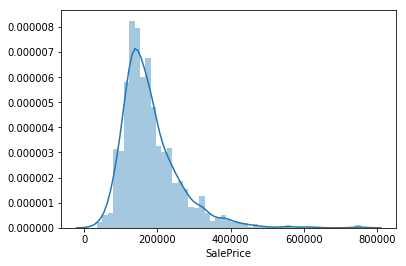

In [7]:
sns.distplot(y_train_full);

We see that we had a little skewness of our data for sure but in fact it's ok more or less

In [8]:
numerical = train_df.dtypes[train_df.dtypes != "object"]
non_numerical = train_df.dtypes[train_df.dtypes == "object"]
print("Numerical features ",len(numerical)),print("Categorical features ",len(non_numerical));

Numerical features  36
Categorical features  43


Let's drop features with half or more missing values or that have little inflence on our price

In [9]:
train_df.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence',
                'MiscFeature', 'MiscVal'],inplace = True,axis = 1)
test_df.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence',
               'MiscFeature', 'MiscVal'],inplace = True,axis = 1)

In [10]:
idx_split = train_df.shape[0]
features = pd.concat([train_df,test_df],axis = 0)

In [11]:
features.isnull().sum()

MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinType2       80
TotalBsmtSF         1
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
GrLivArea           0
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         1
TotRmsAbvGrd        0
Fireplaces          0
FireplaceQ

Filling NA's

In [12]:
# MSZoning
features["MSZoning"].fillna(features["MSZoning"].mode()[0],inplace = True)
# Lot Frontage
features["LotFrontage"].fillna(features['LotFrontage'].mean(),inplace = True)
#Alley
features['Alley'].fillna("NOACESS",inplace = True)
#Exterior1st
features["Exterior1st"].fillna("CBlock",inplace = True)
#Exterior2nd
features["Exterior2nd"].fillna("CBlock",inplace = True)
#MasVnrType
features["MasVnrType"].fillna("None",inplace = True)
#BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
for col in['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
          'BsmtFinType2']:
    features[col].fillna("NoBasement",inplace = True)
#TotalBsmtSF
features["TotalBsmtSF"].fillna("NoBasement",inplace = True)
#Electrical
features["Electrical"].fillna(features["Electrical"].mode()[0],inplace = True)#Most common value
#KitchenQual
features["KitchenQual"].fillna(features["KitchenQual"].mode()[0],inplace = True)
#FireplaceQu
features["FireplaceQu"].fillna("NoFireplace",inplace = True)
#GarageType,GarageFinish,GarageQual
for col in ["GarageType","GarageFinish","GarageQual"]:
    features[col].fillna("NoGarage",inplace = True)
#GarageCars
features["GarageCars"].fillna(features["GarageCars"].mode()[0],inplace = True)
#SaleType
features["SaleType"].fillna("Oth",inplace = True)

In [13]:
columns = features.select_dtypes(include="object").columns.tolist()

Label Encoding of features

In [14]:
encoder = LabelEncoder()
for col in columns:
    features[col] = encoder.fit_transform(features[col].astype('str'))

In [15]:
train_df = features[:idx_split]
test_df = features[idx_split:]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_df,y_train_full)

In [17]:
X_train.shape, y_train.shape

((1095, 55), (1095,))

In [18]:
rf = RandomForestRegressor(n_jobs=-1,random_state=17)

In [19]:
params = {"n_estimators":[10,12,15,17,20],
         "max_depth":[3,5,7,None],
         "max_features":[0.5,0.7,1]}

In [20]:
cv = GridSearchCV(rf,params,"neg_mean_squared_log_error",n_jobs=-1,cv = 5,verbose = 10).fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] max_depth=3, max_features=0.5, n_estimators=10 ..................
[CV] max_depth=3, max_features=0.5, n_estimators=10 ..................
[CV] max_depth=3, max_features=0.5, n_estimators=10 ..................
[CV] max_depth=3, max_features=0.5, n_estimators=10 ..................
[CV]  max_depth=3, max_features=0.5, n_estimators=10, score=-0.05138541272830726, total=   0.3s
[CV]  max_depth=3, max_features=0.5, n_estimators=10, score=-0.03732838151441534, total=   0.3s
[CV]  max_depth=3, max_features=0.5, n_estimators=10, score=-0.04723970581846805, total=   0.2s
[CV]  max_depth=3, max_features=0.5, n_estimators=10, score=-0.0420916835539031, total=   0.3s
[CV] max_depth=3, max_features=0.5, n_estimators=10 ..................
[CV] max_depth=3, max_features=0.5, n_estimators=12 ..................
[CV] max_depth=3, max_features=0.5, n_estimators=12 ..................
[CV] max_depth=3, max_features=0.5, n_estimators=12 ......

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s


[CV]  max_depth=3, max_features=0.5, n_estimators=15, score=-0.053790151140706476, total=   0.2s
[CV]  max_depth=3, max_features=0.5, n_estimators=12, score=-0.04785038257343525, total=   0.3s
[CV] max_depth=3, max_features=0.5, n_estimators=15 ..................
[CV] max_depth=3, max_features=0.5, n_estimators=15 ..................
[CV]  max_depth=3, max_features=0.5, n_estimators=15, score=-0.036395822883424106, total=   0.2s
[CV]  max_depth=3, max_features=0.5, n_estimators=12, score=-0.04292309867567076, total=   0.3s
[CV] max_depth=3, max_features=0.5, n_estimators=15 ..................
[CV] max_depth=3, max_features=0.5, n_estimators=17 ..................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.2s


[CV]  max_depth=3, max_features=0.5, n_estimators=15, score=-0.04250902682986679, total=   0.3s
[CV] max_depth=3, max_features=0.5, n_estimators=17 ..................
[CV]  max_depth=3, max_features=0.5, n_estimators=15, score=-0.048104188094063124, total=   0.3s
[CV] max_depth=3, max_features=0.5, n_estimators=17 ..................
[CV]  max_depth=3, max_features=0.5, n_estimators=15, score=-0.04315426559057645, total=   0.3s
[CV]  max_depth=3, max_features=0.5, n_estimators=17, score=-0.05327527725067979, total=   0.3s
[CV] max_depth=3, max_features=0.5, n_estimators=17 ..................
[CV] max_depth=3, max_features=0.5, n_estimators=17 ..................
[CV]  max_depth=3, max_features=0.5, n_estimators=17, score=-0.0369192220625621, total=   0.2s
[CV] max_depth=3, max_features=0.5, n_estimators=20 ..................
[CV]  max_depth=3, max_features=0.5, n_estimators=17, score=-0.04175974102931941, total=   0.3s
[CV] max_depth=3, max_features=0.5, n_estimators=20 .................

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s


[CV]  max_depth=3, max_features=0.5, n_estimators=20, score=-0.05394373783726628, total=   0.2s
[CV] max_depth=3, max_features=0.5, n_estimators=20 ..................
[CV]  max_depth=3, max_features=0.5, n_estimators=20, score=-0.03660855927426407, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=10 ..................
[CV]  max_depth=3, max_features=0.5, n_estimators=20, score=-0.041809199040578574, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=10 ..................
[CV]  max_depth=3, max_features=0.5, n_estimators=20, score=-0.04888063464652669, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=10 ..................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.4s


[CV]  max_depth=3, max_features=0.5, n_estimators=20, score=-0.041374376376178794, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=10 ..................
[CV]  max_depth=3, max_features=0.7, n_estimators=10, score=-0.056971090211500514, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=10 ..................
[CV]  max_depth=3, max_features=0.7, n_estimators=10, score=-0.03694988798855683, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=12 ..................
[CV]  max_depth=3, max_features=0.7, n_estimators=10, score=-0.043637941196302085, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=12 ..................
[CV]  max_depth=3, max_features=0.7, n_estimators=10, score=-0.04586791862120847, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=12 ..................
[CV]  max_depth=3, max_features=0.7, n_estimators=10, score=-0.04304587152562859, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=12 ..............

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.3s


[CV]  max_depth=3, max_features=0.7, n_estimators=15, score=-0.03661537465879401, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=17 ..................
[CV]  max_depth=3, max_features=0.7, n_estimators=15, score=-0.04284052089263105, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=17 ..................
[CV]  max_depth=3, max_features=0.7, n_estimators=15, score=-0.045978014984037474, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=17 ..................
[CV]  max_depth=3, max_features=0.7, n_estimators=15, score=-0.04371430907110536, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=17 ..................
[CV]  max_depth=3, max_features=0.7, n_estimators=17, score=-0.05578258946696219, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=17 ..................
[CV]  max_depth=3, max_features=0.7, n_estimators=17, score=-0.03703935517029388, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=20 ................

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s


[CV]  max_depth=3, max_features=0.7, n_estimators=17, score=-0.04201433884017649, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=20 ..................
[CV]  max_depth=3, max_features=0.7, n_estimators=20, score=-0.055982998433035926, total=   0.2s
[CV] max_depth=3, max_features=0.7, n_estimators=20 ..................
[CV]  max_depth=3, max_features=0.7, n_estimators=20, score=-0.03682451725864713, total=   0.2s
[CV] max_depth=3, max_features=1, n_estimators=10 ....................
[CV]  max_depth=3, max_features=0.7, n_estimators=20, score=-0.041737260459334576, total=   0.2s
[CV] max_depth=3, max_features=1, n_estimators=10 ....................
[CV]  max_depth=3, max_features=0.7, n_estimators=20, score=-0.04592871551190003, total=   0.2s
[CV] max_depth=3, max_features=1, n_estimators=10 ....................
[CV]  max_depth=3, max_features=0.7, n_estimators=20, score=-0.04144471086198287, total=   0.2s
[CV] max_depth=3, max_features=1, n_estimators=10 .................

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.1s


[CV]  max_depth=3, max_features=1, n_estimators=12, score=-0.07595470280100954, total=   0.2s
[CV] max_depth=3, max_features=1, n_estimators=15 ....................
[CV]  max_depth=3, max_features=1, n_estimators=12, score=-0.06807423408486285, total=   0.2s
[CV] max_depth=3, max_features=1, n_estimators=15 ....................
[CV]  max_depth=3, max_features=1, n_estimators=12, score=-0.10197350475772064, total=   0.2s
[CV] max_depth=3, max_features=1, n_estimators=15 ....................
[CV]  max_depth=3, max_features=1, n_estimators=12, score=-0.0898431725394822, total=   0.2s
[CV] max_depth=3, max_features=1, n_estimators=15 ....................
[CV]  max_depth=3, max_features=1, n_estimators=15, score=-0.10164069249746592, total=   0.2s
[CV] max_depth=3, max_features=1, n_estimators=15 ....................
[CV]  max_depth=3, max_features=1, n_estimators=15, score=-0.0752248395986391, total=   0.2s
[CV] max_depth=3, max_features=1, n_estimators=17 ....................
[CV]  max_de

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.9s


[CV]  max_depth=3, max_features=1, n_estimators=15, score=-0.08799964745138655, total=   0.2s
[CV] max_depth=3, max_features=1, n_estimators=17 ....................
[CV]  max_depth=3, max_features=1, n_estimators=17, score=-0.10432982740133424, total=   0.2s
[CV] max_depth=3, max_features=1, n_estimators=17 ....................
[CV]  max_depth=3, max_features=1, n_estimators=17, score=-0.07584532369828677, total=   0.2s
[CV] max_depth=3, max_features=1, n_estimators=20 ....................
[CV]  max_depth=3, max_features=1, n_estimators=17, score=-0.07043781269817528, total=   0.2s
[CV] max_depth=3, max_features=1, n_estimators=20 ....................
[CV]  max_depth=3, max_features=1, n_estimators=17, score=-0.1022498161678028, total=   0.2s
[CV] max_depth=3, max_features=1, n_estimators=20 ....................
[CV]  max_depth=3, max_features=1, n_estimators=17, score=-0.0881873864942148, total=   0.2s
[CV] max_depth=3, max_features=1, n_estimators=20 ....................
[CV]  max_de

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    7.2s


[CV]  max_depth=5, max_features=0.5, n_estimators=12, score=-0.038978700050411826, total=   0.2s
[CV] max_depth=5, max_features=0.5, n_estimators=12 ..................
[CV]  max_depth=5, max_features=0.5, n_estimators=12, score=-0.027581276963649384, total=   0.2s
[CV] max_depth=5, max_features=0.5, n_estimators=15 ..................
[CV]  max_depth=5, max_features=0.5, n_estimators=12, score=-0.028702054109610513, total=   0.2s
[CV] max_depth=5, max_features=0.5, n_estimators=15 ..................
[CV]  max_depth=5, max_features=0.5, n_estimators=12, score=-0.03369931338547905, total=   0.2s
[CV] max_depth=5, max_features=0.5, n_estimators=15 ..................
[CV]  max_depth=5, max_features=0.5, n_estimators=12, score=-0.028638777646451032, total=   0.2s
[CV] max_depth=5, max_features=0.5, n_estimators=15 ..................
[CV]  max_depth=5, max_features=0.5, n_estimators=15, score=-0.03917536188568112, total=   0.2s
[CV] max_depth=5, max_features=0.5, n_estimators=15 .............

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    8.2s


[CV]  max_depth=5, max_features=0.5, n_estimators=17, score=-0.02759064107395465, total=   0.2s
[CV] max_depth=5, max_features=0.5, n_estimators=20 ..................
[CV]  max_depth=5, max_features=0.5, n_estimators=17, score=-0.03341438355080685, total=   0.2s
[CV] max_depth=5, max_features=0.5, n_estimators=20 ..................
[CV]  max_depth=5, max_features=0.5, n_estimators=17, score=-0.026900365597606248, total=   0.2s
[CV] max_depth=5, max_features=0.5, n_estimators=20 ..................
[CV]  max_depth=5, max_features=0.5, n_estimators=20, score=-0.04043299087192303, total=   0.2s
[CV] max_depth=5, max_features=0.5, n_estimators=20 ..................
[CV]  max_depth=5, max_features=0.5, n_estimators=20, score=-0.026888242402452734, total=   0.2s
[CV] max_depth=5, max_features=0.7, n_estimators=10 ..................
[CV]  max_depth=5, max_features=0.5, n_estimators=20, score=-0.027418154431099996, total=   0.2s
[CV] max_depth=5, max_features=0.7, n_estimators=10 ..............

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    9.5s


[CV]  max_depth=5, max_features=0.7, n_estimators=12, score=-0.036011671126704205, total=   0.2s
[CV] max_depth=5, max_features=0.7, n_estimators=15 ..................
[CV]  max_depth=5, max_features=0.7, n_estimators=12, score=-0.029039622774899163, total=   0.2s
[CV] max_depth=5, max_features=0.7, n_estimators=15 ..................
[CV]  max_depth=5, max_features=0.7, n_estimators=15, score=-0.040902270027881237, total=   0.2s
[CV] max_depth=5, max_features=0.7, n_estimators=15 ..................
[CV]  max_depth=5, max_features=0.7, n_estimators=15, score=-0.026274986962928525, total=   0.2s
[CV] max_depth=5, max_features=0.7, n_estimators=17 ..................
[CV]  max_depth=5, max_features=0.7, n_estimators=15, score=-0.02798196978974478, total=   0.2s
[CV] max_depth=5, max_features=0.7, n_estimators=17 ..................
[CV]  max_depth=5, max_features=0.7, n_estimators=15, score=-0.03545471982628385, total=   0.2s
[CV] max_depth=5, max_features=0.7, n_estimators=17 .............

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   10.7s


[CV]  max_depth=5, max_features=0.7, n_estimators=20, score=-0.02619730029557839, total=   0.2s
[CV] max_depth=5, max_features=1, n_estimators=10 ....................
[CV]  max_depth=5, max_features=0.7, n_estimators=20, score=-0.02736602287769113, total=   0.2s
[CV] max_depth=5, max_features=1, n_estimators=10 ....................
[CV]  max_depth=5, max_features=0.7, n_estimators=20, score=-0.034451289781614464, total=   0.2s
[CV] max_depth=5, max_features=1, n_estimators=10 ....................
[CV]  max_depth=5, max_features=0.7, n_estimators=20, score=-0.02732820384722467, total=   0.2s
[CV] max_depth=5, max_features=1, n_estimators=10 ....................
[CV]  max_depth=5, max_features=1, n_estimators=10, score=-0.07316818339756016, total=   0.2s
[CV] max_depth=5, max_features=1, n_estimators=10 ....................
[CV]  max_depth=5, max_features=1, n_estimators=10, score=-0.04988439302378454, total=   0.2s
[CV] max_depth=5, max_features=1, n_estimators=12 ....................
[

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   12.3s


[CV]  max_depth=5, max_features=1, n_estimators=17, score=-0.07438775155153358, total=   0.2s
[CV] max_depth=5, max_features=1, n_estimators=17 ....................
[CV]  max_depth=5, max_features=1, n_estimators=17, score=-0.05059570586836991, total=   0.2s
[CV] max_depth=5, max_features=1, n_estimators=20 ....................
[CV]  max_depth=5, max_features=1, n_estimators=17, score=-0.0526478690070425, total=   0.2s
[CV] max_depth=5, max_features=1, n_estimators=20 ....................
[CV]  max_depth=5, max_features=1, n_estimators=17, score=-0.07453433327147994, total=   0.2s
[CV] max_depth=5, max_features=1, n_estimators=20 ....................
[CV]  max_depth=5, max_features=1, n_estimators=17, score=-0.061487421997822644, total=   0.2s
[CV] max_depth=5, max_features=1, n_estimators=20 ....................
[CV]  max_depth=5, max_features=1, n_estimators=20, score=-0.07558106105679514, total=   0.2s
[CV] max_depth=5, max_features=1, n_estimators=20 ....................
[CV]  max_

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.7s


[CV]  max_depth=7, max_features=0.5, n_estimators=12, score=-0.023238249988107203, total=   0.2s
[CV] max_depth=7, max_features=0.5, n_estimators=15 ..................
[CV]  max_depth=7, max_features=0.5, n_estimators=12, score=-0.022561468676321392, total=   0.2s
[CV] max_depth=7, max_features=0.5, n_estimators=15 ..................
[CV]  max_depth=7, max_features=0.5, n_estimators=12, score=-0.027902815272264393, total=   0.2s
[CV] max_depth=7, max_features=0.5, n_estimators=15 ..................
[CV]  max_depth=7, max_features=0.5, n_estimators=12, score=-0.025351240111683757, total=   0.2s
[CV] max_depth=7, max_features=0.5, n_estimators=15 ..................
[CV]  max_depth=7, max_features=0.5, n_estimators=15, score=-0.034448926477550226, total=   0.2s
[CV] max_depth=7, max_features=0.5, n_estimators=15 ..................
[CV]  max_depth=7, max_features=0.5, n_estimators=15, score=-0.022628923563610123, total=   0.2s
[CV] max_depth=7, max_features=0.5, n_estimators=17 ...........

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   15.4s


[CV]  max_depth=7, max_features=0.7, n_estimators=10, score=-0.027175693019807746, total=   0.2s
[CV] max_depth=7, max_features=0.7, n_estimators=12 ..................
[CV]  max_depth=7, max_features=0.7, n_estimators=10, score=-0.025550510234170813, total=   0.2s
[CV] max_depth=7, max_features=0.7, n_estimators=12 ..................
[CV]  max_depth=7, max_features=0.7, n_estimators=10, score=-0.029049132922242375, total=   0.2s
[CV] max_depth=7, max_features=0.7, n_estimators=12 ..................
[CV]  max_depth=7, max_features=0.7, n_estimators=10, score=-0.02462468551734233, total=   0.2s
[CV] max_depth=7, max_features=0.7, n_estimators=12 ..................
[CV]  max_depth=7, max_features=0.7, n_estimators=12, score=-0.03456625599488728, total=   0.2s
[CV] max_depth=7, max_features=0.7, n_estimators=12 ..................
[CV]  max_depth=7, max_features=0.7, n_estimators=12, score=-0.0275383367082741, total=   0.2s
[CV] max_depth=7, max_features=0.7, n_estimators=15 ...............

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.9s


[CV]  max_depth=7, max_features=0.7, n_estimators=17, score=-0.02800330919542648, total=   0.2s
[CV] max_depth=7, max_features=0.7, n_estimators=20 ..................
[CV]  max_depth=7, max_features=0.7, n_estimators=17, score=-0.022785910733650203, total=   0.2s
[CV] max_depth=7, max_features=0.7, n_estimators=20 ..................
[CV]  max_depth=7, max_features=0.7, n_estimators=20, score=-0.033561216964673554, total=   0.2s
[CV] max_depth=7, max_features=0.7, n_estimators=20 ..................
[CV]  max_depth=7, max_features=0.7, n_estimators=20, score=-0.024870202364096657, total=   0.2s
[CV] max_depth=7, max_features=1, n_estimators=10 ....................
[CV]  max_depth=7, max_features=0.7, n_estimators=20, score=-0.0231125512406014, total=   0.2s
[CV] max_depth=7, max_features=1, n_estimators=10 ....................
[CV]  max_depth=7, max_features=0.7, n_estimators=20, score=-0.027066962581377776, total=   0.2s
[CV] max_depth=7, max_features=1, n_estimators=10 ................

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   18.8s


[CV]  max_depth=7, max_features=1, n_estimators=17, score=-0.03729319660261362, total=   0.2s
[CV] max_depth=7, max_features=1, n_estimators=20 ....................
[CV]  max_depth=7, max_features=1, n_estimators=17, score=-0.042382329824765426, total=   0.2s
[CV] max_depth=7, max_features=1, n_estimators=20 ....................
[CV]  max_depth=7, max_features=1, n_estimators=17, score=-0.05562211855749939, total=   0.2s
[CV] max_depth=7, max_features=1, n_estimators=20 ....................
[CV]  max_depth=7, max_features=1, n_estimators=17, score=-0.04626177699101133, total=   0.2s
[CV] max_depth=7, max_features=1, n_estimators=20 ....................
[CV]  max_depth=7, max_features=1, n_estimators=20, score=-0.05611568417416893, total=   0.2s
[CV] max_depth=7, max_features=1, n_estimators=20 ....................
[CV]  max_depth=7, max_features=1, n_estimators=20, score=-0.03715805576314903, total=   0.2s
[CV] max_depth=None, max_features=0.5, n_estimators=10 ...............
[CV]  max

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   20.6s


[CV]  max_depth=None, max_features=0.5, n_estimators=15, score=-0.021188232298428162, total=   0.2s
[CV] max_depth=None, max_features=0.5, n_estimators=17 ...............
[CV]  max_depth=None, max_features=0.5, n_estimators=15, score=-0.02242609952920161, total=   0.2s
[CV] max_depth=None, max_features=0.5, n_estimators=17 ...............
[CV]  max_depth=None, max_features=0.5, n_estimators=15, score=-0.025316708848420865, total=   0.2s
[CV] max_depth=None, max_features=0.5, n_estimators=17 ...............
[CV]  max_depth=None, max_features=0.5, n_estimators=15, score=-0.02372972078520716, total=   0.2s
[CV] max_depth=None, max_features=0.5, n_estimators=17 ...............
[CV]  max_depth=None, max_features=0.5, n_estimators=17, score=-0.03136301088712439, total=   0.2s
[CV] max_depth=None, max_features=0.5, n_estimators=17 ...............
[CV]  max_depth=None, max_features=0.5, n_estimators=17, score=-0.021348472284122476, total=   0.2s
[CV] max_depth=None, max_features=0.5, n_estimat

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   22.6s


[CV]  max_depth=None, max_features=0.7, n_estimators=15, score=-0.03374980115252659, total=   0.2s
[CV] max_depth=None, max_features=0.7, n_estimators=15 ...............
[CV]  max_depth=None, max_features=0.7, n_estimators=15, score=-0.024050615957586154, total=   0.2s
[CV] max_depth=None, max_features=0.7, n_estimators=17 ...............
[CV]  max_depth=None, max_features=0.7, n_estimators=15, score=-0.02333130096052596, total=   0.2s
[CV] max_depth=None, max_features=0.7, n_estimators=17 ...............
[CV]  max_depth=None, max_features=0.7, n_estimators=15, score=-0.02580378073597047, total=   0.2s
[CV] max_depth=None, max_features=0.7, n_estimators=17 ...............
[CV]  max_depth=None, max_features=0.7, n_estimators=15, score=-0.022166766645553, total=   0.2s
[CV] max_depth=None, max_features=0.7, n_estimators=17 ...............
[CV]  max_depth=None, max_features=0.7, n_estimators=17, score=-0.033418668159274634, total=   0.2s
[CV] max_depth=None, max_features=0.7, n_estimators

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   24.6s


[CV]  max_depth=None, max_features=1, n_estimators=12, score=-0.03097230224207019, total=   0.2s
[CV] max_depth=None, max_features=1, n_estimators=15 .................
[CV]  max_depth=None, max_features=1, n_estimators=12, score=-0.03382063393763789, total=   0.2s
[CV] max_depth=None, max_features=1, n_estimators=15 .................
[CV]  max_depth=None, max_features=1, n_estimators=12, score=-0.038210731952091966, total=   0.2s
[CV] max_depth=None, max_features=1, n_estimators=15 .................
[CV]  max_depth=None, max_features=1, n_estimators=12, score=-0.03434306417929373, total=   0.2s
[CV] max_depth=None, max_features=1, n_estimators=15 .................
[CV]  max_depth=None, max_features=1, n_estimators=15, score=-0.043074242521027234, total=   0.2s
[CV] max_depth=None, max_features=1, n_estimators=15 .................
[CV]  max_depth=None, max_features=1, n_estimators=15, score=-0.030201392282273906, total=   0.2s
[CV] max_depth=None, max_features=1, n_estimators=17 .......

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.3s finished


In [21]:
mean_squared_log_error(y_test,cv.best_estimator_.predict(X_test))

0.02034970545897598

In [22]:
prediction = cv.best_estimator_.predict(X_test)

In [24]:
prediction_test = cv.best_estimator_.predict(test_df)

In [25]:
pd.DataFrame({'Id': test_df.index.values, 'SalePrice': prediction_test}).to_csv('2018-04-30.csv', index =False)  

#### Score on LB 0.16

## Trying the Yandex CatBoost

In [26]:
CatReg = CatBoostRegressor()

In [27]:
CatReg.fit(train_df,y_train_full)

0:	learn: 192370.7439447	total: 62.9ms	remaining: 1m 2s
1:	learn: 187372.6180491	total: 68.9ms	remaining: 34.4s
2:	learn: 182350.5054289	total: 74.2ms	remaining: 24.6s
3:	learn: 177596.5127172	total: 79.3ms	remaining: 19.8s
4:	learn: 172983.3940218	total: 83.5ms	remaining: 16.6s
5:	learn: 168330.7410503	total: 88.5ms	remaining: 14.7s
6:	learn: 164010.9010027	total: 93.6ms	remaining: 13.3s
7:	learn: 159860.2357765	total: 98.7ms	remaining: 12.2s
8:	learn: 155720.4525432	total: 104ms	remaining: 11.4s
9:	learn: 151705.7884380	total: 109ms	remaining: 10.8s
10:	learn: 147809.4966308	total: 114ms	remaining: 10.3s
11:	learn: 144065.7710943	total: 118ms	remaining: 9.74s
12:	learn: 140502.8930731	total: 123ms	remaining: 9.3s
13:	learn: 136911.8719595	total: 128ms	remaining: 9.01s
14:	learn: 133440.2939970	total: 133ms	remaining: 8.73s
15:	learn: 130120.2325079	total: 138ms	remaining: 8.48s
16:	learn: 126861.2212093	total: 142ms	remaining: 8.21s
17:	learn: 123659.1753501	total: 147ms	remaining: 8

157:	learn: 25607.8935736	total: 1.07s	remaining: 5.72s
158:	learn: 25538.0855892	total: 1.08s	remaining: 5.72s
159:	learn: 25450.3605963	total: 1.09s	remaining: 5.71s
160:	learn: 25387.1157432	total: 1.09s	remaining: 5.7s
161:	learn: 25306.7476323	total: 1.1s	remaining: 5.67s
162:	learn: 25231.5241390	total: 1.1s	remaining: 5.66s
163:	learn: 25138.3425981	total: 1.11s	remaining: 5.64s
164:	learn: 25069.7869289	total: 1.11s	remaining: 5.63s
165:	learn: 25037.4549584	total: 1.12s	remaining: 5.61s
166:	learn: 24973.8408972	total: 1.12s	remaining: 5.6s
167:	learn: 24942.8261645	total: 1.13s	remaining: 5.58s
168:	learn: 24895.6781092	total: 1.13s	remaining: 5.57s
169:	learn: 24854.7654347	total: 1.14s	remaining: 5.56s
170:	learn: 24791.3811455	total: 1.14s	remaining: 5.54s
171:	learn: 24760.9638886	total: 1.15s	remaining: 5.53s
172:	learn: 24705.8431502	total: 1.15s	remaining: 5.51s
173:	learn: 24622.3173623	total: 1.16s	remaining: 5.49s
174:	learn: 24563.4061145	total: 1.16s	remaining: 5.

308:	learn: 20468.2459911	total: 2.07s	remaining: 4.63s
309:	learn: 20431.8738757	total: 2.08s	remaining: 4.62s
310:	learn: 20389.4538831	total: 2.08s	remaining: 4.62s
311:	learn: 20357.8903912	total: 2.09s	remaining: 4.61s
312:	learn: 20335.2834477	total: 2.1s	remaining: 4.6s
313:	learn: 20303.2915932	total: 2.1s	remaining: 4.59s
314:	learn: 20275.7877081	total: 2.11s	remaining: 4.58s
315:	learn: 20267.3617142	total: 2.11s	remaining: 4.57s
316:	learn: 20262.3160970	total: 2.12s	remaining: 4.56s
317:	learn: 20253.3137366	total: 2.12s	remaining: 4.55s
318:	learn: 20221.0667634	total: 2.13s	remaining: 4.54s
319:	learn: 20214.6633093	total: 2.13s	remaining: 4.53s
320:	learn: 20210.2485713	total: 2.13s	remaining: 4.51s
321:	learn: 20195.6817523	total: 2.14s	remaining: 4.51s
322:	learn: 20189.3858042	total: 2.15s	remaining: 4.5s
323:	learn: 20173.2887472	total: 2.15s	remaining: 4.49s
324:	learn: 20168.2121649	total: 2.15s	remaining: 4.48s
325:	learn: 20152.1792656	total: 2.16s	remaining: 4.

456:	learn: 18804.9413753	total: 2.88s	remaining: 3.42s
457:	learn: 18803.5900351	total: 2.89s	remaining: 3.42s
458:	learn: 18803.0512464	total: 2.89s	remaining: 3.41s
459:	learn: 18801.9101299	total: 2.9s	remaining: 3.4s
460:	learn: 18783.2574800	total: 2.9s	remaining: 3.39s
461:	learn: 18753.7961568	total: 2.91s	remaining: 3.38s
462:	learn: 18743.0178557	total: 2.91s	remaining: 3.38s
463:	learn: 18729.1791881	total: 2.92s	remaining: 3.37s
464:	learn: 18728.2887766	total: 2.92s	remaining: 3.36s
465:	learn: 18727.5869718	total: 2.92s	remaining: 3.35s
466:	learn: 18718.0759033	total: 2.93s	remaining: 3.34s
467:	learn: 18716.9482373	total: 2.94s	remaining: 3.34s
468:	learn: 18687.6207230	total: 2.94s	remaining: 3.33s
469:	learn: 18665.8649871	total: 2.94s	remaining: 3.32s
470:	learn: 18665.4050683	total: 2.95s	remaining: 3.31s
471:	learn: 18663.4705807	total: 2.96s	remaining: 3.31s
472:	learn: 18655.9060197	total: 2.96s	remaining: 3.3s
473:	learn: 18655.0710622	total: 2.96s	remaining: 3.

641:	learn: 17686.4784419	total: 3.89s	remaining: 2.17s
642:	learn: 17685.4966743	total: 3.9s	remaining: 2.16s
643:	learn: 17685.2527095	total: 3.91s	remaining: 2.16s
644:	learn: 17680.2133236	total: 3.91s	remaining: 2.15s
645:	learn: 17670.0433847	total: 3.92s	remaining: 2.15s
646:	learn: 17666.7388885	total: 3.92s	remaining: 2.14s
647:	learn: 17630.2892592	total: 3.93s	remaining: 2.13s
648:	learn: 17629.8377802	total: 3.93s	remaining: 2.13s
649:	learn: 17619.5939710	total: 3.94s	remaining: 2.12s
650:	learn: 17610.8523708	total: 3.94s	remaining: 2.11s
651:	learn: 17610.5335184	total: 3.95s	remaining: 2.11s
652:	learn: 17608.9285976	total: 3.95s	remaining: 2.1s
653:	learn: 17608.5428093	total: 3.96s	remaining: 2.1s
654:	learn: 17606.3834930	total: 3.96s	remaining: 2.09s
655:	learn: 17594.3265306	total: 3.97s	remaining: 2.08s
656:	learn: 17594.1852078	total: 3.98s	remaining: 2.08s
657:	learn: 17593.7031299	total: 3.98s	remaining: 2.07s
658:	learn: 17586.7912695	total: 3.98s	remaining: 2

823:	learn: 16896.2387311	total: 4.86s	remaining: 1.04s
824:	learn: 16896.2173961	total: 4.87s	remaining: 1.03s
825:	learn: 16895.1063616	total: 4.87s	remaining: 1.03s
826:	learn: 16886.0424710	total: 4.88s	remaining: 1.02s
827:	learn: 16880.7869666	total: 4.88s	remaining: 1.01s
828:	learn: 16880.6925575	total: 4.89s	remaining: 1.01s
829:	learn: 16878.7165265	total: 4.89s	remaining: 1s
830:	learn: 16876.1839298	total: 4.9s	remaining: 996ms
831:	learn: 16875.8348169	total: 4.9s	remaining: 990ms
832:	learn: 16868.9673809	total: 4.91s	remaining: 984ms
833:	learn: 16868.8388319	total: 4.91s	remaining: 978ms
834:	learn: 16860.1490787	total: 4.92s	remaining: 973ms
835:	learn: 16858.7139441	total: 4.93s	remaining: 967ms
836:	learn: 16858.7000882	total: 4.94s	remaining: 963ms
837:	learn: 16856.0095294	total: 4.95s	remaining: 957ms
838:	learn: 16855.9962235	total: 4.96s	remaining: 951ms
839:	learn: 16855.8924909	total: 4.96s	remaining: 945ms
840:	learn: 16843.1517340	total: 4.97s	remaining: 939

In [28]:
cat_pred = CatReg.predict(X_test)

In [29]:
mean_squared_log_error(y_test,cat_pred)

0.008689989479705808

 Predict the test set

In [30]:
CatReg.fit(X_train,y_train)

0:	learn: 193124.8767296	total: 14ms	remaining: 14s
1:	learn: 188010.8271372	total: 19.6ms	remaining: 9.76s
2:	learn: 183029.4371883	total: 23.6ms	remaining: 7.84s
3:	learn: 178306.8080546	total: 28.3ms	remaining: 7.05s
4:	learn: 173729.4808250	total: 32.9ms	remaining: 6.54s
5:	learn: 169425.2785754	total: 37ms	remaining: 6.14s
6:	learn: 165093.4360143	total: 41.6ms	remaining: 5.9s
7:	learn: 160901.1652454	total: 46.2ms	remaining: 5.73s
8:	learn: 156586.7295075	total: 50.6ms	remaining: 5.57s
9:	learn: 152510.6330323	total: 54.5ms	remaining: 5.4s
10:	learn: 148584.2045588	total: 58.8ms	remaining: 5.28s
11:	learn: 144739.7565532	total: 64.1ms	remaining: 5.27s
12:	learn: 141049.1360348	total: 68.6ms	remaining: 5.21s
13:	learn: 137456.2546245	total: 73.1ms	remaining: 5.15s
14:	learn: 134124.1938575	total: 77.8ms	remaining: 5.11s
15:	learn: 130889.6649428	total: 82.4ms	remaining: 5.07s
16:	learn: 127779.2686844	total: 86.4ms	remaining: 4.99s
17:	learn: 124571.5597086	total: 90.4ms	remaining

185:	learn: 24296.4707899	total: 994ms	remaining: 4.35s
186:	learn: 24223.9115134	total: 1s	remaining: 4.35s
187:	learn: 24188.3527438	total: 1.01s	remaining: 4.36s
188:	learn: 24138.9617082	total: 1.01s	remaining: 4.35s
189:	learn: 24085.0684229	total: 1.02s	remaining: 4.34s
190:	learn: 24032.9020235	total: 1.02s	remaining: 4.34s
191:	learn: 23986.6730591	total: 1.03s	remaining: 4.34s
192:	learn: 23934.8043409	total: 1.04s	remaining: 4.35s
193:	learn: 23893.9842791	total: 1.05s	remaining: 4.36s
194:	learn: 23823.8304342	total: 1.06s	remaining: 4.37s
195:	learn: 23783.9457445	total: 1.07s	remaining: 4.4s
196:	learn: 23757.4061749	total: 1.08s	remaining: 4.41s
197:	learn: 23702.7382273	total: 1.09s	remaining: 4.41s
198:	learn: 23657.3456806	total: 1.09s	remaining: 4.4s
199:	learn: 23595.8635077	total: 1.1s	remaining: 4.39s
200:	learn: 23581.7928785	total: 1.1s	remaining: 4.38s
201:	learn: 23540.3172332	total: 1.11s	remaining: 4.37s
202:	learn: 23500.5327959	total: 1.11s	remaining: 4.36s

367:	learn: 19937.3553639	total: 1.98s	remaining: 3.4s
368:	learn: 19931.2255489	total: 1.99s	remaining: 3.4s
369:	learn: 19913.1822720	total: 1.99s	remaining: 3.39s
370:	learn: 19902.5887662	total: 2s	remaining: 3.39s
371:	learn: 19898.4835778	total: 2s	remaining: 3.38s
372:	learn: 19893.8189567	total: 2.01s	remaining: 3.37s
373:	learn: 19891.0616787	total: 2.01s	remaining: 3.37s
374:	learn: 19858.0202014	total: 2.01s	remaining: 3.36s
375:	learn: 19835.3934454	total: 2.02s	remaining: 3.35s
376:	learn: 19806.9604429	total: 2.02s	remaining: 3.35s
377:	learn: 19802.6256312	total: 2.03s	remaining: 3.34s
378:	learn: 19776.9333171	total: 2.04s	remaining: 3.33s
379:	learn: 19772.6850635	total: 2.04s	remaining: 3.34s
380:	learn: 19770.1041384	total: 2.06s	remaining: 3.34s
381:	learn: 19732.1092570	total: 2.07s	remaining: 3.34s
382:	learn: 19716.3678111	total: 2.07s	remaining: 3.34s
383:	learn: 19713.2629922	total: 2.08s	remaining: 3.33s
384:	learn: 19706.4847208	total: 2.08s	remaining: 3.33s


527:	learn: 18587.8089035	total: 2.76s	remaining: 2.47s
528:	learn: 18580.8460836	total: 2.77s	remaining: 2.47s
529:	learn: 18575.1920126	total: 2.78s	remaining: 2.46s
530:	learn: 18574.3383097	total: 2.78s	remaining: 2.46s
531:	learn: 18574.1328454	total: 2.79s	remaining: 2.45s
532:	learn: 18567.0372772	total: 2.79s	remaining: 2.45s
533:	learn: 18565.9209673	total: 2.79s	remaining: 2.44s
534:	learn: 18562.4547491	total: 2.8s	remaining: 2.43s
535:	learn: 18561.7974441	total: 2.8s	remaining: 2.43s
536:	learn: 18546.0030040	total: 2.81s	remaining: 2.42s
537:	learn: 18545.2673810	total: 2.81s	remaining: 2.42s
538:	learn: 18544.2696887	total: 2.82s	remaining: 2.41s
539:	learn: 18543.0534837	total: 2.82s	remaining: 2.4s
540:	learn: 18542.2305871	total: 2.83s	remaining: 2.4s
541:	learn: 18532.1467318	total: 2.83s	remaining: 2.39s
542:	learn: 18531.0322767	total: 2.83s	remaining: 2.39s
543:	learn: 18530.5114748	total: 2.84s	remaining: 2.38s
544:	learn: 18521.3116745	total: 2.84s	remaining: 2.

694:	learn: 17638.1146758	total: 3.54s	remaining: 1.55s
695:	learn: 17614.3780454	total: 3.55s	remaining: 1.55s
696:	learn: 17614.2934486	total: 3.56s	remaining: 1.55s
697:	learn: 17611.7141175	total: 3.56s	remaining: 1.54s
698:	learn: 17606.9092624	total: 3.57s	remaining: 1.54s
699:	learn: 17605.5671349	total: 3.57s	remaining: 1.53s
700:	learn: 17604.0345258	total: 3.58s	remaining: 1.53s
701:	learn: 17577.1185897	total: 3.58s	remaining: 1.52s
702:	learn: 17572.0555462	total: 3.59s	remaining: 1.51s
703:	learn: 17568.7254867	total: 3.59s	remaining: 1.51s
704:	learn: 17567.0281099	total: 3.59s	remaining: 1.5s
705:	learn: 17566.8093533	total: 3.6s	remaining: 1.5s
706:	learn: 17561.4742328	total: 3.6s	remaining: 1.49s
707:	learn: 17553.9965765	total: 3.61s	remaining: 1.49s
708:	learn: 17550.2741137	total: 3.61s	remaining: 1.48s
709:	learn: 17546.8384736	total: 3.62s	remaining: 1.48s
710:	learn: 17544.3080354	total: 3.62s	remaining: 1.47s
711:	learn: 17542.9629372	total: 3.63s	remaining: 1.

857:	learn: 16860.3756918	total: 4.34s	remaining: 718ms
858:	learn: 16859.3623918	total: 4.35s	remaining: 713ms
859:	learn: 16854.3908030	total: 4.35s	remaining: 708ms
860:	learn: 16853.8695269	total: 4.36s	remaining: 703ms
861:	learn: 16846.6414102	total: 4.36s	remaining: 698ms
862:	learn: 16845.4092813	total: 4.36s	remaining: 693ms
863:	learn: 16845.0391320	total: 4.37s	remaining: 688ms
864:	learn: 16844.7627075	total: 4.37s	remaining: 683ms
865:	learn: 16844.4599350	total: 4.38s	remaining: 677ms
866:	learn: 16822.5698130	total: 4.38s	remaining: 672ms
867:	learn: 16802.5250044	total: 4.39s	remaining: 667ms
868:	learn: 16802.3225334	total: 4.39s	remaining: 662ms
869:	learn: 16790.8224385	total: 4.39s	remaining: 657ms
870:	learn: 16788.1598562	total: 4.4s	remaining: 652ms
871:	learn: 16775.8038314	total: 4.4s	remaining: 646ms
872:	learn: 16775.5882553	total: 4.41s	remaining: 641ms
873:	learn: 16774.7637747	total: 4.41s	remaining: 636ms
874:	learn: 16773.8888006	total: 4.42s	remaining: 

In [31]:
cat_test = CatReg.predict(test_df)

In [32]:
pd.DataFrame({'Id': test_df.index.values, 'SalePrice': cat_test}).to_csv('2018-05-04_CatBoost_tuned_estimators.csv', index =False)  

#### LB Score 0.13141

## XGBoost Time

In [33]:
xgb = XGBRegressor(random_state=17)

In [34]:
xgb_result = xgb.fit(X_train,y_train).predict(X_test)

In [35]:
mean_squared_log_error(y_test,xgb_result)

0.01583772149384051

In [36]:
xgb_boost = xgb.fit(train_df,y_train_full).predict(test_df)

In [37]:
pd.DataFrame({'Id': test_df.index.values, 'SalePrice': xgb_boost}).to_csv('2018-05-01_xgb_untuned.csv', index =False)  

#### LB Score 0.13846

XGB Params tuning

In [76]:
params = {
         "learning_rate":[0.0001,0.001,0.01,0.1],
         "n_estimators":[100,200,300,400,500],
         "colsample_bylevel":[0.5,0.7,1]}

In [40]:
xgb_tuned = GridSearchCV(xgb,params,n_jobs=-1,verbose=10,return_train_score=True,cv = 5).fit(train_df,y_train_full)

Fitting 5 folds for each of 780 candidates, totalling 3900 fits
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=100 
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=100 
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=100 
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=100, score=-5.840080294549933, total=   0.2s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=100, score=-4.980713108567441, total=   0.2s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=100, score=-4.398626488846509, total=   0.2s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=200 
[CV

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=200, score=-4.868379052896705, total=   0.4s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=200, score=-5.712538915969097, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=200, score=-4.303433802736372, total=   0.4s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=200, score=-5.646883097602048, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=200, score=-4.737342874861369, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_e

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=300, score=-5.5875131584770275, total=   0.7s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=300, score=-4.758424585914372, total=   0.8s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=300, score=-4.209741750191931, total=   0.8s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=300, score=-5.517932952125885, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=300, score=-4.632550229705098, total=   0.8s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=400, score=-4.11772476574575, total=   1.2s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=400, score=-5.391173402693483, total=   1.2s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=400, score=-4.5298400165052675, total=   1.1s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=500, score=-5.344762823650683, total=   1.2s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=500, score=-4.544173082405565, total=   1.1s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_e

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.0s


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=3, n_estimators=500, score=-5.267165240399025, total=   1.1s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=100, score=-4.980116756642333, total=   0.3s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=100, score=-4.3985406259222115, total=   0.3s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=100, score=-5.7785293912228, total=   0.3s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=100, score=-4.844652107584924, total=   0.3s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_es

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=200, score=-4.7378341146028236, total=   0.6s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=300, score=-5.584523437320625, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=300, score=-4.755996123794628, total=   1.0s
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=300, score=-4.209454713357484, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=400 
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=300, score=-5.517778675947581, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.5s


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=400, score=-4.117447332408135, total=   1.2s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=400, score=-5.3906978585193945, total=   1.1s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=400, score=-4.530768747418337, total=   1.1s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=500, score=-5.34015941199891, total=   1.4s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=4, n_estimators=500, score=-4.540348169688495, total=   1.4s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_e

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.4s


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=200, score=-5.710789749102549, total=   0.7s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=200, score=-4.866573052119358, total=   0.7s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=200, score=-4.302772267499174, total=   0.7s
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=200, score=-5.646089043815906, total=   0.7s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=300 
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=200, score=-4.7382002338812885, total=   0.7s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.8s


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=300, score=-4.634082509716102, total=   1.4s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=400, score=-5.461344234355104, total=   1.8s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=400, score=-4.64650961392335, total=   1.8s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=400, score=-4.116901160623681, total=   1.8s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=400, score=-5.390111117633706, total=   1.5s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_es

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.5s


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=5, n_estimators=500, score=-4.431036226380411, total=   1.7s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=100, score=-4.844367431574646, total=   0.4s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=200, score=-5.710860922298735, total=   0.8s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=200, score=-4.8659407078589645, total=   0.8s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=200, score=-4.302872112604481, total=   0.8s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   22.0s


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=400, score=-5.4618203611405765, total=   1.6s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=400, score=-4.64601680391517, total=   1.6s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=400, score=-4.116759111776058, total=   1.6s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=400, score=-5.390222086046645, total=   1.6s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_estimators=400, score=-4.530690021489024, total=   1.6s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=6, n_e

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   26.6s


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=7, n_estimators=200, score=-5.711329624970757, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=7, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=7, n_estimators=200, score=-4.8662623921628345, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=7, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=7, n_estimators=200, score=-4.303286574895299, total=   0.9s
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=7, n_estimators=200, score=-5.646580047254861, total=   0.8s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=7, n_estimators=300 
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=7, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=7, n_estimators=200, score=-4.737939832623162, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=7, n_

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   32.4s


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=7, n_estimators=500, score=-5.341438236216884, total=   2.2s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=7, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=7, n_estimators=500, score=-4.5389263121952075, total=   2.2s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_estimators=100, score=-5.839046994110678, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=7, n_estimators=500, score=-4.026983770599512, total=   2.1s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_estimators=100, score=-4.979973607670793, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   37.4s


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_estimators=300, score=-5.517085935882931, total=   1.4s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_estimators=300, score=-4.633456712862401, total=   1.4s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_estimators=400, score=-5.462159727815287, total=   1.8s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_estimators=400, score=-4.646195466970802, total=   1.8s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_estimators=400, score=-4.117015396496715, total=   1.7s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_e

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   43.7s


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=8, n_estimators=500, score=-4.430285453252481, total=   2.3s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=9, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=9, n_estimators=200, score=-4.866385454932923, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=9, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=9, n_estimators=200, score=-5.71108190075987, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=9, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=9, n_estimators=200, score=-4.302773348735184, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=9, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=9, n_estimators=200, score=-5.646534494210835, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=9, n_es

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   51.6s


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=100, score=-4.398394363681366, total=   0.4s
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=100, score=-4.979773638540168, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=100 
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=9, n_estimators=500, score=-5.266140260304597, total=   2.4s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=100, score=-5.778432060812447, total=   0.5s
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=100, score=-4.844614485968939, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=200 
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_dept

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   57.2s


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=400, score=-4.116871255430323, total=   1.8s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=400, score=-5.390170295609604, total=   1.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=400, score=-4.530607701655262, total=   1.8s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=500, score=-5.342234821563415, total=   2.3s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=10, n_estimators=500, score=-4.539215800070436, total=   2.3s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_dep

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.1min


[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=11, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=11, n_estimators=300, score=-4.633270544113713, total=   1.4s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=11, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=11, n_estimators=400, score=-5.462707252695919, total=   1.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=11, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=11, n_estimators=400, score=-4.646002939043722, total=   1.8s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=11, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=11, n_estimators=400, score=-4.116868306239956, total=   1.8s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=11, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=11, n_estimators=400, score=-5.390090

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.2min


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=12, n_estimators=300, score=-5.585422958453755, total=   1.4s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=12, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=12, n_estimators=300, score=-4.755211512566185, total=   1.4s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=12, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=12, n_estimators=300, score=-4.209020362557535, total=   1.3s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=12, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=12, n_estimators=300, score=-5.5171806080964885, total=   1.4s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=12, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=12, n_estimators=300, score=-4.633270544113713, total=   1.5s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_de

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.3min


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=13, n_estimators=200, score=-5.64646119627785, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=13, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=13, n_estimators=200, score=-4.737787109043597, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=13, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=13, n_estimators=300, score=-5.585422958453755, total=   1.5s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=13, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=13, n_estimators=300, score=-4.755211512566185, total=   1.5s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=13, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=13, n_estimators=300, score=-4.209020362557535, total=   1.4s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_dept

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.5min


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=14, n_estimators=200, score=-4.866499553100194, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=14, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=14, n_estimators=200, score=-4.30277911718636, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=14, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=14, n_estimators=200, score=-5.64646119627785, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=14, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=14, n_estimators=200, score=-4.737787109043597, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=14, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=14, n_estimators=300, score=-4.755211512566185, total=   1.3s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.6min


[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=15, n_estimators=200, score=-4.866499553100194, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=15, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=15, n_estimators=200, score=-4.30277911718636, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=15, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=15, n_estimators=200, score=-5.64646119627785, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=15, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=15, n_estimators=200, score=-4.737787109043597, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.0001, max_depth=15, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=15, n_estimators=300, score=-5.585422958453755, total=   1.4s
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_dept

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.8min


[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=3, n_estimators=200, score=-2.8589783597327, total=   0.4s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=3, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=3, n_estimators=200, score=-3.6777075058230233, total=   0.4s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=3, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=3, n_estimators=200, score=-3.128610768706091, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=3, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=3, n_estimators=300, score=-2.984240944630247, total=   0.6s
[CV]  colsample_bylevel=0.5, learning_rate=0.0001, max_depth=15, n_estimators=500, score=-4.430205747244063, total=   2.4s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=3, n_estimators=300 
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=3, n_estimators

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min


[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=4, n_estimators=200, score=-3.1301082485112897, total=   0.6s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=4, n_estimators=300, score=-2.9607353729293235, total=   0.8s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=4, n_estimators=300, score=-2.454317554973387, total=   0.8s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=4, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=4, n_estimators=300, score=-2.2424730043819885, total=   0.8s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=4, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=4, n_estimators=300, score=-2.849392137005909, total=   0.8s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=4, n_estimato

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.9min


[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=5, n_estimators=200, score=-3.132511342877402, total=   0.7s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=5, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=5, n_estimators=300, score=-2.9657357497499945, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=5, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=5, n_estimators=300, score=-2.4486944087564186, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=5, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=5, n_estimators=300, score=-2.24173896453802, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=5, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=5, n_estimators=300, score=-2.8446304504371214, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=5, n_estimator

[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  2.1min


[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=6, n_estimators=300, score=-2.845761072726314, total=   1.2s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=6, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=6, n_estimators=300, score=-2.451404975098375, total=   1.2s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=6, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=6, n_estimators=400, score=-2.298514064126552, total=   1.6s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=6, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=6, n_estimators=400, score=-1.8601776858167178, total=   1.6s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=6, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=6, n_estimators=400, score=-1.7268984818633033, total=   1.6s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=6, n_estimator

[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.2min


[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=7, n_estimators=400, score=-1.7297378679964273, total=   1.7s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=7, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=7, n_estimators=400, score=-2.1722572915740144, total=   1.7s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=7, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=7, n_estimators=400, score=-1.8943953014699675, total=   1.8s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=7, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=7, n_estimators=500, score=-1.7471857602872365, total=   2.2s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=7, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=7, n_estimators=500, score=-1.3797607904582527, total=   2.2s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=8, n_estima

[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:  2.5min


[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=9, n_estimators=100, score=-4.034275926127342, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=9, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=9, n_estimators=100, score=-3.6006384459654273, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=9, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=8, n_estimators=500, score=-1.6193027327488339, total=   2.4s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=9, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=9, n_estimators=100, score=-4.682331391996141, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=9, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=9, n_estimators=100, score=-3.9563995553089404, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=9, n_estimato

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  2.6min


[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=9, n_estimators=500, score=-1.430627988368794, total=   2.5s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=10, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=10, n_estimators=200, score=-3.781296394346415, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=10, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=10, n_estimators=200, score=-3.1650884153631074, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=10, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=10, n_estimators=200, score=-2.8581659698643187, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=10, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=10, n_estimators=200, score=-3.6716699586813144, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=10, n

[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed:  2.8min


[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=11, n_estimators=300, score=-2.240401971202065, total=   1.4s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=11, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=11, n_estimators=300, score=-2.846935786554668, total=   1.4s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=11, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=11, n_estimators=300, score=-2.450674610332314, total=   1.4s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=11, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=11, n_estimators=400, score=-2.3017019597277177, total=   2.0s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=11, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=11, n_estimators=400, score=-1.8609682066313837, total=   1.9s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=11, n

[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:  3.0min


[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=12, n_estimators=500, score=-1.7470503894372604, total=   2.5s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=12, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=12, n_estimators=500, score=-1.3787667382962727, total=   2.4s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=13, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=13, n_estimators=100, score=-4.772815058160231, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=13, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=12, n_estimators=500, score=-1.304927756511343, total=   2.4s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=13, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=13, n_estimators=100, score=-4.035635677509775, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=13, n

[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  3.3min


[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=14, n_estimators=200, score=-3.1650884153631074, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=14, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=14, n_estimators=200, score=-2.8578899220481095, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=14, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=14, n_estimators=200, score=-3.6718882140518994, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=14, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=14, n_estimators=200, score=-3.1313757144429983, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=14, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=14, n_estimators=300, score=-2.9688219107809557, total=   1.5s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=14

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.5min


[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=15, n_estimators=400, score=-2.3022349412056156, total=   1.9s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=15, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=15, n_estimators=400, score=-1.8614564418999924, total=   1.9s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=15, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=15, n_estimators=400, score=-1.7295582676600105, total=   1.9s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=15, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=15, n_estimators=400, score=-2.173403392440064, total=   1.9s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=15, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.001, max_depth=15, n_estimators=400, score=-1.8914136503065215, total=   2.0s
[CV] colsample_bylevel=0.5, learning_rate=0.001, max_depth=15,

[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed:  3.6min


[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=4, n_estimators=200, score=0.7305247086905029, total=   0.6s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=4, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=4, n_estimators=200, score=0.6902964052676748, total=   0.6s
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=4, n_estimators=200, score=0.7355146757690418, total=   0.6s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=4, n_estimators=300 
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=4, n_estimators=200, score=0.7607659437171029, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=4, n_estimators=200, score=0.6953123787980058, total=   0.6s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=4, n_estimators=300 
[CV] 

[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed:  3.8min


[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=5, n_estimators=300, score=0.8242722038676837, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=5, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=5, n_estimators=400, score=0.8967083974179552, total=   1.4s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=5, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=5, n_estimators=400, score=0.8476647396420377, total=   1.3s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=5, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=5, n_estimators=400, score=0.8730698975850331, total=   1.3s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=5, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=5, n_estimators=400, score=0.8986384889013252, total=   1.3s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=5, n_estimators=500 
[CV] 

[Parallel(n_jobs=-1)]: Done 753 tasks      | elapsed:  4.0min


[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=7, n_estimators=100, score=-0.060631523285311406, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=7, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=7, n_estimators=200, score=0.7308491919980885, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=7, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=7, n_estimators=200, score=0.7367946781629188, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=7, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=7, n_estimators=200, score=0.6963418218799118, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=7, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=7, n_estimators=200, score=0.7669727279388604, total=   1.0s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=7, n_estimators=300 
[C

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.2min


[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=8, n_estimators=400, score=0.8689629120467133, total=   2.1s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=8, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=8, n_estimators=400, score=0.9071406628356764, total=   2.1s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=8, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=8, n_estimators=400, score=0.8529336046795903, total=   2.1s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=8, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=8, n_estimators=500, score=0.8936229910046017, total=   2.7s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=8, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=8, n_estimators=500, score=0.8407051679554973, total=   2.7s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=9, n_estimators=100 
[CV] 

[Parallel(n_jobs=-1)]: Done 833 tasks      | elapsed:  4.5min


[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, score=0.7668519822498852, total=   1.2s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=10, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=10, n_estimators=200, score=0.6903262460443856, total=   1.2s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=10, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=10, n_estimators=300, score=0.867057699163506, total=   1.9s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=10, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=10, n_estimators=300, score=0.8290576546851369, total=   1.9s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=10, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=10, n_estimators=300, score=0.8345384665206312, total=   1.9s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=10, n_estimators=4

[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  4.9min


[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=12, n_estimators=100, score=0.014992968039556187, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=12, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=12, n_estimators=100, score=-0.03630967986329625, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=12, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=12, n_estimators=100, score=-0.033193756379537254, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=12, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=11, n_estimators=500, score=0.9052117547596246, total=   3.6s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=12, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=12, n_estimators=100, score=-0.07265336711982706, total=   0.6s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=12, n_es

[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=13, n_estimators=400, score=0.8870912203340081, total=   3.3s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=13, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=13, n_estimators=400, score=0.8479966942878082, total=   3.2s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=13, n_estimators=500 


[Parallel(n_jobs=-1)]: Done 917 tasks      | elapsed:  5.3min


[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=13, n_estimators=400, score=0.8665196965696713, total=   3.3s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=13, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=13, n_estimators=400, score=0.9014830774979629, total=   3.2s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=13, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=13, n_estimators=400, score=0.8535819081942683, total=   3.2s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=13, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=13, n_estimators=500, score=0.8922583605623229, total=   4.2s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=13, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=13, n_estimators=500, score=0.8493278114199098, total=   4.1s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=14, n_estimators=

[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=15, n_estimators=200, score=0.7678987319943302, total=   1.3s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=15, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=15, n_estimators=200, score=0.6877760925734347, total=   1.3s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=15, n_estimators=300 


[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:  5.7min


[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=15, n_estimators=300, score=0.8631871433630078, total=   2.3s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=15, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=15, n_estimators=300, score=0.8341422635667229, total=   2.2s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=15, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=15, n_estimators=300, score=0.8350847942998836, total=   2.2s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=15, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=15, n_estimators=300, score=0.8832872861922842, total=   2.2s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=15, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.01, max_depth=15, n_estimators=300, score=0.8236966417803897, total=   2.3s
[CV] colsample_bylevel=0.5, learning_rate=0.01, max_depth=15, n_estimators=

[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=100, score=0.888912664925327, total=   0.3s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=100, score=0.909071945583047, total=   0.3s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=100, score=0.8749479853295445, total=   0.3s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=200 


[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.0min


[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=200, score=0.857474262438908, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=200, score=0.9088580628546904, total=   0.6s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=200, score=0.887461685845344, total=   0.6s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=200, score=0.9123726473609086, total=   0.6s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=200, score=0.8758912520729562, total=   0.6s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=4, n_estimators=300 
[CV]  colsample_b

[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, score=0.8870146979753568, total=   0.4s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, score=0.8953263684026626, total=   1.6s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, score=0.8275974927928873, total=   0.4s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, score=0.896334291745993, total=   1.6s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, score=0.8812066063543492, total=   0.4s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=200 


[Parallel(n_jobs=-1)]: Done 1050 tasks      | elapsed:  6.2min


[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, score=0.8561178418534149, total=   1.6s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, score=0.900527724352645, total=   0.4s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, score=0.8705272754663471, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, score=0.8884364418159145, total=   0.8s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=200 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, score=0.8805415865707833, total=   0.8s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=6, n_estimators=300 
[CV]  colsample_

[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=7, n_estimators=400, score=0.8532897223336519, total=   1.9s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=7, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, score=0.8797846209797024, total=   2.3s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=7, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, score=0.8423306676377456, total=   2.3s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done 1097 tasks      | elapsed:  6.4min


[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=8, n_estimators=100, score=0.8821253249768806, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=8, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, score=0.8760785995226176, total=   2.3s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=8, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=8, n_estimators=100, score=0.8168619688848894, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=8, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=8, n_estimators=100, score=0.877056809890669, total=   0.5s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=8, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, score=0.8903532430032133, total=   2.4s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=8, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=9, n_estimators=300, score=0.8508589937808599, total=   1.8s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=9, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=9, n_estimators=400, score=0.8877748960346349, total=   2.4s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=9, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=9, n_estimators=400, score=0.8501971443543169, total=   2.4s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=9, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=9, n_estimators=400, score=0.8790336538873056, total=   2.4s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=9, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=9, n_estimators=400, score=0.8947568205600123, total=   2.5s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=9, n_estimators=500 


[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  6.8min


[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=9, n_estimators=400, score=0.850848237872904, total=   2.4s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=9, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=9, n_estimators=500, score=0.8877761311713307, total=   3.0s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=9, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=9, n_estimators=500, score=0.8501962983386766, total=   3.1s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=10, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=10, n_estimators=100, score=0.8808618440334701, total=   0.7s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=10, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=9, n_estimators=500, score=0.8790345114380804, total=   3.0s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=10, n_estimators=100 
[CV]  colsam

[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=300, score=0.8563854780777043, total=   2.3s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=300, score=0.8738680435740717, total=   2.3s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=300, score=0.8932791377566494, total=   2.3s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=300, score=0.8690904200796288, total=   2.3s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=400, score=0.8794341847205933, total=   3.0s
[CV] 

[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed:  7.2min


[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=400, score=0.8932788673338136, total=   3.1s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=400, score=0.8690893220613052, total=   3.2s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=500, score=0.8794341054207202, total=   3.9s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=11, n_estimators=500, score=0.8563857120206048, total=   4.0s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=12, n_estimators=100 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=12, n_estimators=100, score=0.8667761032457715, total=   0.9s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=12, n_estimators=100 
[CV] 

[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=300, score=0.8669300117040073, total=   2.7s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=300, score=0.8393169050930217, total=   2.7s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=300, score=0.8841859589502046, total=   2.7s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=300, score=0.8863251752014406, total=   2.7s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=300, score=0.8585216980560562, total=   2.7s
[CV] 

[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  7.7min


[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=400, score=0.884185959301826, total=   3.6s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=400, score=0.8863251537312312, total=   3.6s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=400, score=0.8585215368958816, total=   3.6s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=500, score=0.8669300744008952, total=   4.4s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=13, n_estimators=500, score=0.8393171507075066, total=   4.4s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=14, n_estimators=100 
[CV]  

[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=200, score=0.8632716018057849, total=   2.0s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=300, score=0.8647651673765765, total=   3.1s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=300 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=300, score=0.8548518640783604, total=   3.1s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=300, score=0.8851326475976237, total=   3.1s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=400 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=300, score=0.8929634365166635, total=   3.1s
[CV] 

[Parallel(n_jobs=-1)]: Done 1293 tasks      | elapsed:  8.4min


[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=400, score=0.8929634782273297, total=   4.0s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=400, score=0.8632736031934953, total=   4.0s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=500, score=0.8647655212837838, total=   4.9s
[CV] colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=500 
[CV]  colsample_bylevel=0.5, learning_rate=0.1, max_depth=15, n_estimators=500, score=0.8548513398362282, total=   5.0s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=3, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=3, n_estimators=100, score=-5.840750122832723, total=   0.3s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=3, n_estimators=100 

[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=4, n_estimators=200, score=-4.738966043969997, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=4, n_estimators=300, score=-5.586546735093075, total=   1.1s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=4, n_estimators=300, score=-4.752823744024418, total=   1.1s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=4, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=4, n_estimators=300, score=-4.2105013709057255, total=   1.1s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=4, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=4, n_estimators=300, score=-5.515084798466127

[Parallel(n_jobs=-1)]: Done 1344 tasks      | elapsed:  8.7min


[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=4, n_estimators=400, score=-4.532643851944452, total=   1.5s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=4, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=4, n_estimators=500, score=-5.3431491392487676, total=   1.8s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=4, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=4, n_estimators=500, score=-4.5359097056128865, total=   1.8s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=5, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=4, n_estimators=500, score=-4.029021969502311, total=   1.8s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=5, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=5, n_estimators=100, score=-5.839778502685923, total=   0.5s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=5, n

[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=6, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=6, n_estimators=300, score=-5.588334413746185, total=   1.6s
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=6, n_estimators=300, score=-4.752788648034288, total=   1.6s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=6, n_estimators=400 
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=6, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=6, n_estimators=300, score=-4.209597849061589, total=   1.5s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=6, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=6, n_estimators=300, score=-5.515321397661813, total=   1.5s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=6, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=6, n_estimators=300, score=-4.634106215770348,

[Parallel(n_jobs=-1)]: Done 1397 tasks      | elapsed:  9.0min


[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=7, n_estimators=100, score=-5.840067955546875, total=   0.6s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=7, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=6, n_estimators=500, score=-4.027171725948159, total=   2.6s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=7, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=7, n_estimators=100, score=-4.979180228237145, total=   0.6s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=7, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=6, n_estimators=500, score=-5.263276847521893, total=   2.6s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=7, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=7, n_estimators=100, score=-4.39850813496868, total=   0.6s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=7, n_es

[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=8, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=8, n_estimators=300, score=-5.515631976304394, total=   1.9s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=8, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=8, n_estimators=300, score=-4.63391369864103, total=   1.9s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=8, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=8, n_estimators=400, score=-5.465237131936186, total=   2.4s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=8, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=8, n_estimators=400, score=-4.643373814056845, total=   2.4s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=8, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=8, n_estimators=400, score=-4.117619056775152, 

[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.4min


[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=9, n_estimators=100, score=-4.398517269385052, total=   0.6s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=9, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=8, n_estimators=500, score=-5.263343077753423, total=   3.1s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=9, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=9, n_estimators=100, score=-5.777494126271545, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=9, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=9, n_estimators=100, score=-4.8447101465753475, total=   0.6s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=9, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=8, n_estimators=500, score=-4.431064199229362, total=   3.2s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=9, n_

[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=10, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=10, n_estimators=400, score=-4.64341558086243, total=   2.4s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=10, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=10, n_estimators=400, score=-4.117249083480761, total=   2.3s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=10, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=10, n_estimators=400, score=-5.388025869620353, total=   2.5s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=10, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=10, n_estimators=400, score=-4.53174116342368, total=   2.5s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=10, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=10, n_estimators=500, score=-5.34547423

[Parallel(n_jobs=-1)]: Done 1505 tasks      | elapsed:  9.8min


[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=11, n_estimators=200, score=-4.302845484458558, total=   1.2s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=11, n_estimators=200, score=-4.865195254709331, total=   1.2s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=11, n_estimators=200, score=-5.644920158468755, total=   1.3s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=11, n_estimators=200, score=-4.738378723809708, total=   1.3s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=11, n_estimators=300, score=-4.75316497274979, total=   1.8s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_dept

[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=12, n_estimators=500, score=-4.535777379562453, total=   3.0s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=13, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=13, n_estimators=100, score=-5.840097847680539, total=   0.6s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=13, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=12, n_estimators=500, score=-4.0271410468522495, total=   2.9s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=13, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=13, n_estimators=100, score=-4.97904890495434, total=   0.6s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=13, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=13, n_estimators=100, score=-4.39836591585451, total=   0.6s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_dept

[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 10.2min


[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=13, n_estimators=300, score=-5.587777798391146, total=   1.9s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=13, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=13, n_estimators=300, score=-4.75316497274979, total=   1.8s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=13, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=13, n_estimators=300, score=-4.209314339300363, total=   1.7s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=13, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=13, n_estimators=300, score=-5.515427258707914, total=   1.9s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=13, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=13, n_estimators=300, score=-4.633954278893411, total=   1.9s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_dept

[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=15, n_estimators=100, score=-4.39836591585451, total=   0.9s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=15, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=14, n_estimators=500, score=-5.263145807929391, total=   4.0s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=15, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=15, n_estimators=100, score=-5.777464896799011, total=   0.8s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=15, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=15, n_estimators=100, score=-4.84455702000502, total=   0.8s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=15, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=14, n_estimators=500, score=-4.431480314770653, total=   4.1s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth

[Parallel(n_jobs=-1)]: Done 1617 tasks      | elapsed: 10.8min


[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=15, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=15, n_estimators=400, score=-5.387994639487393, total=   3.5s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=15, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=15, n_estimators=400, score=-4.53174116342368, total=   3.4s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=15, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=15, n_estimators=500, score=-4.535777379562453, total=   3.9s
[CV] colsample_bylevel=0.7, learning_rate=0.0001, max_depth=15, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.0001, max_depth=15, n_estimators=500, score=-5.345202896309127, total=   4.2s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=3, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=3, n_estimators=100, score=-4.78550018072

[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=4, n_estimators=200, score=-3.139604386942144, total=   1.0s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=4, n_estimators=300, score=-2.971670909462462, total=   1.5s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=4, n_estimators=300, score=-2.4347484929205154, total=   1.5s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=4, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=4, n_estimators=300, score=-2.2455494160410057, total=   1.5s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=4, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=4, n_estimators=300, score=-2.8349111544161887, total=

[Parallel(n_jobs=-1)]: Done 1674 tasks      | elapsed: 11.2min


[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=5, n_estimators=100, score=-4.025933582227538, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=5, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=4, n_estimators=500, score=-1.6103588858206312, total=   2.6s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=5, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=5, n_estimators=100, score=-3.598145369257171, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=5, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=5, n_estimators=100, score=-4.67486616461906, total=   0.6s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=5, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=4, n_estimators=500, score=-1.4468054735042202, total=   2.6s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=5, n_estimators

[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=6, n_estimators=400, score=-2.3082762338739378, total=   2.1s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=6, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=6, n_estimators=400, score=-1.844370468216907, total=   2.1s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=6, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=6, n_estimators=400, score=-1.730417287704035, total=   2.1s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=6, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=6, n_estimators=400, score=-2.161841640666933, total=   2.1s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=6, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=6, n_estimators=400, score=-1.91037209831739, total=   2.1s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=6, n_estimators=

[Parallel(n_jobs=-1)]: Done 1733 tasks      | elapsed: 11.6min


[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=7, n_estimators=200, score=-3.135712823011162, total=   1.2s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=7, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=7, n_estimators=300, score=-2.9809529101387304, total=   1.8s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=7, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=7, n_estimators=300, score=-2.437066180036235, total=   1.8s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=7, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=7, n_estimators=300, score=-2.241585935654998, total=   1.8s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=7, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=7, n_estimators=300, score=-2.838744148115329, total=   1.8s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=7, n_estimators

[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimators=100, score=-3.600986848843097, total=   0.6s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=8, n_estimators=500, score=-1.6110192678169664, total=   3.2s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimators=100, score=-4.673437154221639, total=   0.6s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimators=100, score=-3.955768246937997, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=8, n_estimators=500, score=-1.4472569490108467, total=   3.2s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimator

[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 12.0min


[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimators=400, score=-1.7294305314111207, total=   2.5s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimators=400, score=-2.1622626280996986, total=   2.6s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimators=400, score=-1.910304464492445, total=   2.6s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimators=500, score=-1.7514695916594367, total=   3.3s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=9, n_estimators=500, score=-1.3676796806489104, total=   3.2s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=10, n_estima

[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=11, n_estimators=200, score=-3.66067400236349, total=   1.3s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=11, n_estimators=200, score=-3.133685983014918, total=   1.3s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=11, n_estimators=300, score=-2.437749438609148, total=   1.9s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=11, n_estimators=300, score=-2.982685950202108, total=   2.0s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=11, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=11, n_estimators=300, score=-2.2411790011183834,

[Parallel(n_jobs=-1)]: Done 1853 tasks      | elapsed: 12.6min


[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=12, n_estimators=200, score=-3.7955583042996475, total=   1.3s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=12, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=12, n_estimators=200, score=-3.154646486165011, total=   1.3s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=12, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=12, n_estimators=200, score=-2.8561532150340505, total=   1.3s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=12, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=11, n_estimators=500, score=-1.4421266338153194, total=   3.5s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=12, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=12, n_estimators=200, score=-3.66067400236349, total=   1.3s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=12, n

[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=13, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=13, n_estimators=500, score=-1.7541874678166898, total=   3.4s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=13, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=13, n_estimators=500, score=-1.3687592946643001, total=   3.4s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=14, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=14, n_estimators=100, score=-4.777811391196856, total=   0.6s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=14, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=13, n_estimators=500, score=-1.3040355466029752, total=   3.3s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=14, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=14, n_estimators=100, score=-4.0311733829819

[Parallel(n_jobs=-1)]: Done 1914 tasks      | elapsed: 13.1min


[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=14, n_estimators=300, score=-2.4619349874655394, total=   2.1s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=14, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=14, n_estimators=400, score=-2.308696503389929, total=   2.7s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=14, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=14, n_estimators=400, score=-1.8492574554285313, total=   2.6s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=14, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=14, n_estimators=400, score=-1.7294803461156492, total=   2.6s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=14, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.001, max_depth=14, n_estimators=400, score=-2.1607011935132405, total=   2.7s
[CV] colsample_bylevel=0.7, learning_rate=0.001, max_depth=14,

[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=3, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, score=0.715607073527591, total=   0.6s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=3, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, score=0.6680411459928401, total=   0.6s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=3, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, score=0.7401186426964582, total=   0.5s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=3, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, score=0.6551873485512658, total=   0.6s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=3, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=3, n_estimators=300, score=0.842671343861486, total=   0.8s
[CV] co

[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 13.5min


[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, score=0.725511272981784, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=4, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, score=0.7371949262478485, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, score=0.6859254050878465, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, score=0.7605938447088146, total=   0.8s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, score=0.678825364930439, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=4, n_estimators=300 
[CV]  c

[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, score=-0.1297223356408963, total=   0.5s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, score=0.8802722599722146, total=   2.2s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, score=0.030042714543522142, total=   0.5s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, score=0.896209020290451, total=   2.2s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, score=-0.03997442177623567, total=   0.6s
[

[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed: 13.8min


[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=400, score=0.8830136229244493, total=   2.2s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=400, score=0.8386137369752298, total=   2.2s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=400, score=0.8633603014374771, total=   2.2s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=400, score=0.899290746026644, total=   2.1s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=400, score=0.8339049269667118, total=   2.1s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=6, n_estimators=500 
[CV]  

[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=8, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=8, n_estimators=200, score=0.6940493055918724, total=   1.4s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=8, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=8, n_estimators=200, score=0.76610924390664, total=   1.4s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=8, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=8, n_estimators=200, score=0.6691763060033171, total=   1.4s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=8, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=8, n_estimators=300, score=0.8557584966096704, total=   2.1s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=8, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=8, n_estimators=300, score=0.8297150261520818, total=   2.1s
[CV] co

[Parallel(n_jobs=-1)]: Done 2105 tasks      | elapsed: 14.4min


[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, score=0.7179939753238623, total=   1.5s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=9, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, score=0.7293401396649808, total=   1.5s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=9, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, score=0.6904118463559353, total=   1.5s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=9, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, score=0.7681014608469775, total=   1.5s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=9, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, score=0.6822098565724639, total=   1.5s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=9, n_estimators=300 
[CV] 

[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=10, n_estimators=500, score=0.83126240349925, total=   4.4s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=11, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=11, n_estimators=100, score=-0.13568859094137542, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=11, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=10, n_estimators=500, score=0.8711613155537454, total=   4.4s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=11, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=11, n_estimators=100, score=0.02442943145208998, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=11, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=11, n_estimators=100, score=-0.03627035802220857, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=11, n_estimato

[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed: 15.1min


[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=11, n_estimators=500, score=0.88371619363277, total=   4.8s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=11, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=11, n_estimators=500, score=0.834664352543314, total=   4.8s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=12, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=12, n_estimators=100, score=-0.13275765439169107, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=12, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=11, n_estimators=500, score=0.8696522227843666, total=   4.8s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=12, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=12, n_estimators=100, score=0.023164328111664915, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=12, n_estimators

[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=13, n_estimators=300, score=0.8257534876384326, total=   2.9s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=13, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=13, n_estimators=300, score=0.8302520686498797, total=   2.9s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=13, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=13, n_estimators=300, score=0.8805370613965599, total=   2.9s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=13, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=13, n_estimators=300, score=0.8143491117737088, total=   2.9s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=13, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=13, n_estimators=400, score=0.8784465355724403, total=   4.2s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=13, n_estimators=

[Parallel(n_jobs=-1)]: Done 2237 tasks      | elapsed: 15.9min


[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=14, n_estimators=300, score=0.8329897401876314, total=   3.0s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=14, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=14, n_estimators=300, score=0.879669019350184, total=   3.0s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=14, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=14, n_estimators=300, score=0.8176163012033677, total=   3.0s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=14, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=14, n_estimators=400, score=0.8789697752036939, total=   4.2s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=14, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.01, max_depth=14, n_estimators=400, score=0.828321981139238, total=   4.3s
[CV] colsample_bylevel=0.7, learning_rate=0.01, max_depth=14, n_estimators=50

[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, score=0.9012556110057262, total=   0.5s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=3, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, score=0.8552071267807315, total=   0.5s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=3, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, score=0.8869999081783873, total=   0.5s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=3, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, score=0.8957616277193227, total=   0.5s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=3, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, score=0.8881872522875713, total=   0.5s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=3, n_estimators=300 
[CV]  colsample

[Parallel(n_jobs=-1)]: Done 2304 tasks      | elapsed: 16.6min


[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=4, n_estimators=200, score=0.9138528552466175, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=4, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=4, n_estimators=200, score=0.8457315046204457, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=4, n_estimators=200, score=0.8929231908332332, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=4, n_estimators=200, score=0.8968066165226234, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=4, n_estimators=200, score=0.871509729612207, total=   0.7s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=4, n_estimators=300 
[CV]  colsample_

[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, score=0.8797750470425519, total=   0.5s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=5, n_estimators=500, score=0.8753302547808897, total=   2.2s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, score=0.8373367018241272, total=   0.6s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=5, n_estimators=500, score=0.8985513811480605, total=   2.2s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, score=0.8787765525824278, total=   0.5s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=6, n_estimators=200 
[CV]  colsample

[Parallel(n_jobs=-1)]: Done 2373 tasks      | elapsed: 17.0min


[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=6, n_estimators=500, score=0.8775422578915402, total=   3.3s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=7, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, score=0.8427335843272504, total=   0.9s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=7, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, score=0.872748143582035, total=   0.8s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=7, n_estimators=100 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=6, n_estimators=500, score=0.9022529138623914, total=   3.5s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=7, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, score=0.8853348350403413, total=   0.8s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=7, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=8, n_estimators=400, score=0.8796328618773444, total=   2.9s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=8, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=8, n_estimators=400, score=0.8153574158084267, total=   2.9s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=8, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=8, n_estimators=400, score=0.8665883468385029, total=   2.9s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=8, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=8, n_estimators=400, score=0.8917751030984351, total=   2.9s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=8, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=8, n_estimators=400, score=0.8723137851619408, total=   2.9s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=8, n_estimators=500 
[CV]  colsample

[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 17.6min


[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=9, n_estimators=400, score=0.8824982653084685, total=   3.2s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=9, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=9, n_estimators=400, score=0.8979333109831286, total=   3.2s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=9, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=9, n_estimators=400, score=0.8556551523423228, total=   3.3s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=9, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=9, n_estimators=500, score=0.8812262531831455, total=   4.1s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=9, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=9, n_estimators=500, score=0.8353953658505254, total=   4.1s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=10, n_estimators=100 
[CV]  colsampl

[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=11, n_estimators=200, score=0.8600007927785497, total=   2.0s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=11, n_estimators=300, score=0.8850094380573679, total=   3.0s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=11, n_estimators=300, score=0.8129211076105552, total=   3.0s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=11, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=11, n_estimators=300, score=0.8695961720198977, total=   3.0s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=11, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=11, n_estimators=300, score=0.8905805377563248, total=   3.0s
[CV] 

[Parallel(n_jobs=-1)]: Done 2513 tasks      | elapsed: 18.5min


[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=12, n_estimators=300, score=0.89398662168213, total=   3.3s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=12, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=12, n_estimators=300, score=0.8648142481221816, total=   3.3s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=12, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=12, n_estimators=400, score=0.8846614502849005, total=   4.4s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=12, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=12, n_estimators=400, score=0.819303733579468, total=   4.4s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=12, n_estimators=500 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=12, n_estimators=400, score=0.8721251274110667, total=   4.4s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=12, n_estimators=500 
[CV]  co

[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=14, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=14, n_estimators=200, score=0.8851904706078523, total=   2.6s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=14, n_estimators=200 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=14, n_estimators=200, score=0.8240888314678718, total=   2.6s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=14, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=14, n_estimators=200, score=0.8688594146181594, total=   2.5s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=14, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=14, n_estimators=200, score=0.8937251307920133, total=   2.5s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=14, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=14, n_estimators=200, score=0.8669580091179516, total=   2.5s
[CV] 

[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 19.6min


[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=15, n_estimators=200, score=0.8701480453789449, total=   2.7s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=15, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=15, n_estimators=300, score=0.884705886222823, total=   4.1s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=15, n_estimators=300 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=15, n_estimators=300, score=0.8289366914106127, total=   4.1s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=15, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=15, n_estimators=300, score=0.8686432785585206, total=   4.1s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=15, n_estimators=400 
[CV]  colsample_bylevel=0.7, learning_rate=0.1, max_depth=15, n_estimators=300, score=0.892853566302368, total=   4.1s
[CV] colsample_bylevel=0.7, learning_rate=0.1, max_depth=15, n_estimators=400 
[CV]  c

[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=4, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=4, n_estimators=100, score=-4.400135543124535, total=   0.5s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=4, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=4, n_estimators=100, score=-5.776766597459509, total=   0.5s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=4, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=4, n_estimators=100, score=-4.843535093759775, total=   0.5s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=4, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=3, n_estimators=500, score=-4.428892780788375, total=   1.9s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=4, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=4, n_estimators=200, score=-5.716759024339758, total=   1.0s
[CV] 

[Parallel(n_jobs=-1)]: Done 2657 tasks      | elapsed: 20.3min


[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=5, n_estimators=200, score=-4.735635974751777, total=   1.2s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=5, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=5, n_estimators=300, score=-5.593608030046864, total=   1.8s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=5, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=5, n_estimators=300, score=-4.74962747041147, total=   1.8s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=5, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=5, n_estimators=300, score=-4.210567664601901, total=   1.8s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=5, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=5, n_estimators=300, score=-5.512916487527981, total=   1.9s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=5, n_estimators=400 
[CV]  

[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=7, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=7, n_estimators=100, score=-4.398900708376186, total=   0.8s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=7, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=7, n_estimators=100, score=-5.776635750856935, total=   0.8s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=7, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=6, n_estimators=500, score=-4.435880226795237, total=   3.5s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=7, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=7, n_estimators=100, score=-4.843323982285453, total=   0.8s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=7, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=7, n_estimators=200, score=-5.717203355475497, total=   1.6s
[CV] 

[Parallel(n_jobs=-1)]: Done 2730 tasks      | elapsed: 20.9min


[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=8, n_estimators=200, score=-5.717292301026712, total=   1.6s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=8, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=8, n_estimators=200, score=-4.862689343405804, total=   1.7s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=8, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=8, n_estimators=200, score=-4.303645394129377, total=   1.6s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=8, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=8, n_estimators=200, score=-5.6431673674682274, total=   1.7s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=8, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=8, n_estimators=200, score=-4.735606651659842, total=   1.7s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=8, n_estimators=300 
[CV]

[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=10, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=10, n_estimators=100, score=-5.842230858385203, total=   0.8s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=10, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=9, n_estimators=500, score=-4.028976251780637, total=   4.0s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=10, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=10, n_estimators=100, score=-4.977781631552405, total=   0.9s
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=10, n_estimators=100, score=-4.398900708376186, total=   0.8s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=10, n_estimators=100 
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=10, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=9, n_estimators=500, score=-5.259857989795183, total=   4.

[Parallel(n_jobs=-1)]: Done 2805 tasks      | elapsed: 21.7min


[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=11, n_estimators=200, score=-4.303645394129377, total=   1.6s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=11, n_estimators=200, score=-4.862689343405804, total=   1.7s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=11, n_estimators=200, score=-5.6431673674682274, total=   1.7s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=11, n_estimators=200, score=-4.735606651659842, total=   1.7s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=11, n_estimators=300, score=-5.594789865927336, total=   2.5s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=11, n_estimators

[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=12, n_estimators=500, score=-4.028976251780637, total=   3.9s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=13, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=13, n_estimators=100, score=-5.842230858385203, total=   0.8s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=13, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=13, n_estimators=100, score=-4.398900708376186, total=   0.8s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=13, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=13, n_estimators=100, score=-4.977781631552405, total=   0.8s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=13, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=12, n_estimators=500, score=-5.259857989795183, total=   4.4s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=13, n_estimators=

[Parallel(n_jobs=-1)]: Done 2880 tasks      | elapsed: 22.5min


[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=14, n_estimators=200, score=-4.303645394129377, total=   1.6s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=14, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=13, n_estimators=500, score=-4.435660531261583, total=   4.4s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=14, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=14, n_estimators=200, score=-4.862689343405804, total=   1.7s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=14, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=14, n_estimators=200, score=-5.6431673674682274, total=   1.7s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=14, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=14, n_estimators=200, score=-4.735606651659842, total=   1.7s
[CV] colsample_bylevel=1, learning_rate=0.0001, max_depth=14, n_estimators

[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=15, n_estimators=500, score=-4.530950869364659, total=   4.2s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=3, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=3, n_estimators=100, score=-4.799437443480032, total=   0.4s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=3, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=3, n_estimators=100, score=-4.023471160126363, total=   0.4s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=3, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.0001, max_depth=15, n_estimators=500, score=-4.028976251780637, total=   3.9s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=3, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=3, n_estimators=100, score=-3.610790846053126, total=   0.4s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=3, n_estimators=100 
[CV]  colsa

[Parallel(n_jobs=-1)]: Done 2957 tasks      | elapsed: 23.2min


[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=4, n_estimators=200, score=-3.1847737123614195, total=   1.0s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=4, n_estimators=300, score=-2.977751315490329, total=   1.5s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=4, n_estimators=300, score=-2.4179424024087255, total=   1.5s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=4, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=4, n_estimators=300, score=-2.26580930097398, total=   1.5s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=4, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=4, n_estimators=300, score=-2.8256313046277874, total=   1.5s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=4, n_estimators=400 
[CV]  colsamp

[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=6, n_estimators=100, score=-3.605745398824851, total=   0.8s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=6, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=6, n_estimators=100, score=-4.669432686114449, total=   0.7s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=6, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=5, n_estimators=500, score=-1.4978034753218537, total=   3.1s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=6, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=6, n_estimators=100, score=-3.982012646960473, total=   0.7s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=6, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=6, n_estimators=200, score=-3.8165195646484156, total=   1.5s
[CV] colsampl

[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed: 23.8min


[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=7, n_estimators=200, score=-3.1824590916152404, total=   1.6s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=7, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=7, n_estimators=300, score=-2.989640126483123, total=   2.4s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=7, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=7, n_estimators=300, score=-2.2522280452753174, total=   2.4s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=7, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=7, n_estimators=300, score=-2.429633772052912, total=   2.5s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=7, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=7, n_estimators=300, score=-2.83195813209303, total=   2.4s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=7, n_estimators=400 
[CV]  colsampl

[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=9, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=8, n_estimators=500, score=-1.615941009399119, total=   4.5s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=9, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=9, n_estimators=100, score=-4.66847659043728, total=   0.9s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=9, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=9, n_estimators=100, score=-3.9821555029238747, total=   0.9s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=9, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=8, n_estimators=500, score=-1.495969608302453, total=   4.5s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=9, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=9, n_estimators=200, score=-3.1426606991384087, total=   1.7s
[CV] colsample

[Parallel(n_jobs=-1)]: Done 3113 tasks      | elapsed: 24.7min


[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=10, n_estimators=300, score=-2.8318240195311195, total=   2.7s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=10, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=10, n_estimators=300, score=-2.5054664105855973, total=   2.7s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=10, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=10, n_estimators=400, score=-2.313297287166827, total=   3.7s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=10, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=10, n_estimators=400, score=-1.8446162936430661, total=   3.7s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=10, n_estimators=500 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=10, n_estimators=400, score=-1.7363079380724518, total=   3.5s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=10, n_estimators=500 
[

[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=12, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=12, n_estimators=200, score=-3.1426606991384087, total=   1.7s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=12, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=12, n_estimators=200, score=-2.8667979049672287, total=   1.7s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=12, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=11, n_estimators=500, score=-1.495970729385205, total=   4.7s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=12, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=12, n_estimators=200, score=-3.657775681513111, total=   1.8s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=12, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=12, n_estimators=200, score=-3.1821867250251357, total=   1.8s
[C

[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 25.6min


[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=13, n_estimators=400, score=-2.161893219118946, total=   3.7s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=13, n_estimators=500 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=13, n_estimators=400, score=-1.950122743545113, total=   3.6s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=13, n_estimators=500 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=13, n_estimators=500, score=-1.7613605560278007, total=   4.7s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=13, n_estimators=500 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=13, n_estimators=500, score=-1.3640415076398225, total=   4.6s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=14, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=14, n_estimators=100, score=-4.796736346521557, total=   0.9s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=14, n_estimators=100 
[CV

[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=15, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=15, n_estimators=300, score=-2.4296608880360804, total=   2.7s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=15, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=15, n_estimators=300, score=-2.99196665342172, total=   2.8s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=15, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=15, n_estimators=300, score=-2.252029133212934, total=   2.6s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=15, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=15, n_estimators=300, score=-2.8318240195311195, total=   2.8s
[CV] colsample_bylevel=1, learning_rate=0.001, max_depth=15, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.001, max_depth=15, n_estimators=300, score=-2.5054664105855973, total=   2.7s
[CV

[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 26.4min


[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=4, n_estimators=100, score=-0.12596472094264244, total=   0.5s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=4, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=3, n_estimators=500, score=0.8828206356215916, total=   1.9s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=4, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=4, n_estimators=100, score=0.01969285933802878, total=   0.6s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=4, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=4, n_estimators=100, score=-0.05046937606737756, total=   0.5s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=4, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=4, n_estimators=100, score=-0.03487067708998315, total=   0.5s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=4, n_estimators=200 
[CV]  colsample_by

[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=5, n_estimators=400, score=0.8753584882761771, total=   2.5s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=5, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=5, n_estimators=400, score=0.8211940875363368, total=   2.4s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=5, n_estimators=500 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=5, n_estimators=400, score=0.8591589016708813, total=   2.4s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=5, n_estimators=500 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=5, n_estimators=400, score=0.8985695268876872, total=   2.5s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=5, n_estimators=500 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=5, n_estimators=400, score=0.8190292336109664, total=   2.5s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=5, n_estimators=500 
[CV]  colsample_bylevel=1

[Parallel(n_jobs=-1)]: Done 3354 tasks      | elapsed: 27.1min


[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=7, n_estimators=200, score=0.7056832477542928, total=   1.8s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=7, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=7, n_estimators=200, score=0.7315800282716572, total=   1.7s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=7, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=7, n_estimators=200, score=0.6843932976897282, total=   1.8s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=7, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=7, n_estimators=200, score=0.768501460646495, total=   1.7s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=7, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=7, n_estimators=200, score=0.6454212787885231, total=   1.7s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=7, n_estimators=300 
[CV]  colsample_bylevel=1,

[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=9, n_estimators=100, score=-0.14612798171265196, total=   1.0s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=9, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=8, n_estimators=500, score=0.8567693262662758, total=   4.9s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=9, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=9, n_estimators=100, score=0.019777633848385823, total=   1.0s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=9, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=9, n_estimators=100, score=-0.021248744007172915, total=   1.0s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=9, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=8, n_estimators=500, score=0.9035106125430772, total=   5.0s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=9, n_estimators=200 
[CV]  colsample_by

[Parallel(n_jobs=-1)]: Done 3437 tasks      | elapsed: 33.5min


[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=10, n_estimators=300, score=0.8147202219549616, total=   4.4s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=10, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=10, n_estimators=300, score=0.8844649232719841, total=   4.9s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=10, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=10, n_estimators=300, score=0.7842342877386934, total=   4.8s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=10, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=10, n_estimators=400, score=0.8596689419535785, total=   6.5s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=10, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=10, n_estimators=400, score=0.8071521147929036, total=   6.0s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=10, n_estimators=500 
[CV]  colsample

[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=12, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=12, n_estimators=200, score=0.7008708171013481, total=   2.4s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=12, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=12, n_estimators=200, score=0.7285568705020116, total=   2.4s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=12, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=12, n_estimators=200, score=0.6848350116319666, total=   2.3s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=12, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=11, n_estimators=500, score=0.8402325562711408, total=   6.8s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=12, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=12, n_estimators=200, score=0.7602061316393518, total=   2.4s
[CV] colsample_

[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed: 35.0min


[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=13, n_estimators=500, score=0.8631747923519278, total=   8.6s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=13, n_estimators=500 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=13, n_estimators=500, score=0.81090054204128, total=   8.7s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=14, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=14, n_estimators=100, score=-0.14642309792310382, total=   1.2s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=14, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=14, n_estimators=100, score=0.01936923098542509, total=   1.3s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=14, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=13, n_estimators=500, score=0.8523936074446002, total=   8.7s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=14, n_estimators=100 
[CV]  colsampl

[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=15, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=15, n_estimators=300, score=0.8138877305579784, total=   4.7s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=15, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=15, n_estimators=300, score=0.8841441700808237, total=   4.6s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=15, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=15, n_estimators=300, score=0.7822649552631005, total=   4.8s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=15, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=15, n_estimators=400, score=0.8569236357668393, total=   6.9s
[CV] colsample_bylevel=1, learning_rate=0.01, max_depth=15, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.01, max_depth=15, n_estimators=400, score=0.810582560788159, total=   6.9s
[CV] colsample_b

[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=4, n_estimators=200 
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=4, n_estimators=200 


[Parallel(n_jobs=-1)]: Done 3605 tasks      | elapsed: 36.3min


[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=4, n_estimators=200, score=0.9064169613806021, total=   1.2s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=4, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=4, n_estimators=200, score=0.8663338998561501, total=   1.2s
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=4, n_estimators=200, score=0.898281633154713, total=   1.2s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=4, n_estimators=300 
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=4, n_estimators=200, score=0.8764385112518635, total=   1.3s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=4, n_estimators=200, score=0.852476549350887, total=   1.1s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=4, n_estimators=300 
[CV]  colsample_bylevel=1, learning_r

[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=5, n_estimators=500, score=0.877556392539678, total=   3.4s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=5, n_estimators=500, score=0.8984939175392559, total=   3.3s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=6, n_estimators=100, score=0.8182900285808465, total=   0.8s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=6, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=6, n_estimators=100, score=0.869439136264446, total=   0.7s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=6, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=5, n_estimators=500, score=0.8454033682542244, total=   3.2s
[CV] colsample_bylevel=1, learning_ra

[Parallel(n_jobs=-1)]: Done 3690 tasks      | elapsed: 37.2min


[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=7, n_estimators=400, score=0.8771826145923164, total=   3.6s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=7, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=7, n_estimators=400, score=0.8245423902879461, total=   3.6s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=7, n_estimators=500 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=7, n_estimators=400, score=0.8674370866202389, total=   3.4s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=7, n_estimators=500 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=7, n_estimators=400, score=0.9010294694733901, total=   3.5s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=7, n_estimators=500 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=7, n_estimators=400, score=0.841520874318035, total=   3.6s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=7, n_estimators=500 
[CV]  colsample_bylevel=1, learning_

[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=9, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=9, n_estimators=200, score=0.9029440442698454, total=   2.3s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=9, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=9, n_estimators=200, score=0.8473305459233521, total=   2.3s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=9, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=9, n_estimators=300, score=0.867498059751512, total=   3.3s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=9, n_estimators=300 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=9, n_estimators=300, score=0.8136563666118968, total=   3.4s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=9, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=9, n_estimators=300, score=0.862813858454416, total=   3.3s
[CV] colsample_bylevel=1, learning_ra

[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=11, n_estimators=100, score=0.8567209906084875, total=   1.4s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=11, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=10, n_estimators=500, score=0.8983980871355156, total=   6.3s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=11, n_estimators=200 


[Parallel(n_jobs=-1)]: Done 3777 tasks      | elapsed: 38.4min


[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=11, n_estimators=100, score=0.8997482873655992, total=   1.4s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=11, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=11, n_estimators=100, score=0.8363021718526819, total=   1.4s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=11, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=10, n_estimators=500, score=0.849539874252572, total=   6.3s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=11, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=11, n_estimators=200, score=0.8614613126302115, total=   2.8s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=11, n_estimators=200 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=11, n_estimators=200, score=0.810440063540053, total=   2.8s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=11, n_estimators=300 
[CV]  colsample_bylevel=1, 

[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=12, n_estimators=500 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=12, n_estimators=500, score=0.8665514934725208, total=   8.2s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=12, n_estimators=500 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=12, n_estimators=500, score=0.8070344114842797, total=   8.4s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=13, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=13, n_estimators=100, score=0.8650823474559565, total=   1.8s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=13, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=12, n_estimators=500, score=0.8587213217843248, total=   8.6s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=13, n_estimators=100 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=13, n_estimators=100, score=0.8071493760747442, total=   2.0s
[CV] colsample_bylevel=1,

[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=14, n_estimators=300, score=0.858040843386328, total=   5.3s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=14, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=14, n_estimators=300, score=0.8964084327555788, total=   5.4s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=14, n_estimators=400 


[Parallel(n_jobs=-1)]: Done 3864 tasks      | elapsed: 40.2min


[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=14, n_estimators=300, score=0.8449649840637807, total=   5.3s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=14, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=14, n_estimators=400, score=0.8643220001075876, total=   7.0s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=14, n_estimators=400 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=14, n_estimators=400, score=0.8127093256252178, total=   7.0s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=14, n_estimators=500 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=14, n_estimators=400, score=0.8580415517902159, total=   7.0s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=14, n_estimators=500 
[CV]  colsample_bylevel=1, learning_rate=0.1, max_depth=14, n_estimators=400, score=0.8964082056875119, total=   7.0s
[CV] colsample_bylevel=1, learning_rate=0.1, max_depth=14, n_estimators=500 
[CV]  colsample_bylevel=1

[Parallel(n_jobs=-1)]: Done 3900 out of 3900 | elapsed: 41.2min finished


In [41]:
tuned_xgb = xgb_tuned.best_estimator_.predict(test_df)

In [43]:
pd.DataFrame({'Id': test_df.index.values, 'SalePrice': tuned_xgb}).to_csv('2018-05-05_xgb_tuned.csv', index =False)  

### LB Score 0.13490

In [44]:
X_test.head()

MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
Id                                                                         
421          90         4    78.000000     7060       1      1         3   
691         120         4    69.305795     4426       1      1         3   
87           60         3   122.000000    11911       1      1         1   
337          20         3    86.000000    14157       1      1         0   
418          70         3    86.000000    22420       1      1         0   

     LandContour  LotConfig  LandSlope      ...        FireplaceQu  \
Id                                          ...                      
421            3          4          0      ...                  3   
691            3          4          0      ...                  5   
87             3          4          0      ...                  2   
337            1          0          0      ...                  2   
418            3          4          0      ...                  2   

     GarageType  GarageFinish  GarageCars  GarageQual  PavedDrive  MoSold  \
Id                                                                          
421           1             0         4.0           5           2      11   
691           1             2         2.0           5           2       5   
87            3             0         2.0           5           2       3   
337           1             0         3.0           5           2       7   
418           5             3         3.0           5           0      11   

     YrSold  SaleType  SaleCondition  
Id                                    
421    2008         8              2  
691    2008         8              4  
87     2009         8              4  
337    2007         8              4  
418    2007         8              4  

[5 rows x 55 columns]

In [45]:
lr = LinearRegression()

In [46]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
lr_prediction = lr.predict(X_test)

In [48]:
mean_squared_log_error(y_test,lr_prediction)

0.030661514501654264

Logistic Regression Parameters tuning

In [49]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df)

In [62]:
lr_prediction = lr.fit(train_df,y_train_full).predict(test_df)

In [63]:
pd.DataFrame({'Id': test_df.index.values, 'SalePrice': lr_prediction}).to_csv('2018-05-01_linear_regression.csv', index =False)  

#### LB Score 0.17 

In [64]:
stacked_algoritm = 0.5 * xgb_boost + 0.5 * lr_prediction

In [65]:
stacked_algoritm.shape

(1459,)

In [ ]:
pd.DataFrame({'Id': test_df.index.values, 'SalePrice': stacked_algoritm}).to_csv('2018-05-01_xgb+lin_reg.csv', index =False)  

In [ ]:
cat_pred.shape

In [81]:
Cat_xgb = 0.5 * cat_test + 0.5 * xgb_boost 

In [82]:
Cat_xgb.shape

(1459,)

In [83]:
pd.DataFrame({'Id': test_df.index.values, 'SalePrice': Cat_xgb}).to_csv('2018-05-05_Cat_xgb.csv', index =False)  

Lb Score 0.13